<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-+-Constants" data-toc-modified-id="Imports-+-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports + Constants</a></span></li><li><span><a href="#Inspect-a-single-TFRecord-File" data-toc-modified-id="Inspect-a-single-TFRecord-File-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inspect a single TFRecord File</a></span></li><li><span><a href="#Process-TFRecords" data-toc-modified-id="Process-TFRecords-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process TFRecords</a></span><ul class="toc-item"><li><span><a href="#2009---2011" data-toc-modified-id="2009---2011-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>2009 - 2011</a></span></li><li><span><a href="#2012---2014" data-toc-modified-id="2012---2014-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>2012 - 2014</a></span></li><li><span><a href="#2015---2017" data-toc-modified-id="2015---2017-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>2015 - 2017</a></span></li></ul></li></ul></div>

Pre-requisites:

1. Run `preprocessing/split_surveys.py`.
2. Download TFRecords from Google Earth Engine into `data/dhs_tfrecords_raw/`.

Inspects and processes DHS TFRecords. Inputs are:

- CSVs: filenames are `{country}_{year}.csv`, columns are `['cluster_index', 'lat', 'lon', 'wealth', 'wealthpooled', 'wealthpooled5country', 'households', 'urban_rural']`
- TFRecords: 3-year Landsat 5/7/8 composites, with DMSP (pre-2012) or VIIRS (2012 or after) nightlights, filenames are `lx_median_{year_range}_{country}_dhslocs_ee_export.tfrecord.gz'`

Verifies that the fields in the TFRecords match the CSVs.

Splits each monolithic TFRecord file exported from Google Earth Engine into one file per record.

## Imports + Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pprint import pprint
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append('../')
from preprocessing.helper import get_first_feature_map, get_feature_types
from utils.geo_plot import setup_ax

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

COUNTRIES_2009_11 = [
    'angola_2011', 'burkina_faso_2010', 'cameroon_2011', 'ethiopia_2010', 'lesotho_2009',
    'malawi_2010', 'mozambique_2009', 'mozambique_2011', 'nigeria_2010', 'rwanda_2010',
    'senegal_2010', 'tanzania_2010', 'tanzania_2011', 'uganda_2009', 'uganda_2011',
    'zimbabwe_2010']

COUNTRIES_2012_14 = [
    'benin_2012', 'burkina_faso_2014', 'cote_d_ivoire_2012', 'democratic_republic_of_congo_2013',
    'ghana_2014', 'guinea_2012', 'kenya_2014', 'lesotho_2014', 'malawi_2012', 'malawi_2014',
    'mali_2012', 'nigeria_2013', 'rwanda_2014', 'senegal_2012', 'sierra_leone_2013',
    'togo_2013', 'uganda_2014', 'zambia_2013']

COUNTRIES_2015_17 = [
    'angola_2015', 'ethiopia_2016', 'ghana_2016', 'kenya_2015', 'malawi_2015', 'mali_2015',
    'nigeria_2015', 'tanzania_2015', 'zimbabwe_2015']

TFRECORD_PATH_TEMPLATE = '../data/dhs_tfrecords_raw/lx_median_{year_range}_{country}_dhslocs_ee_export.tfrecord.gz'
SURVEYS_ROOT_DIR = '../data/dhs_surveys/'
OUT_ROOT_DIR = '../data/dhs_tfrecords/'

In [4]:
COUNTRIES_TO_YEARS = {
    'angola': [2011, 2015],
    'benin': [2012],
    'burkina': [2010],
    'burkina_faso': [2014],
    'cameroon': [2011],
    'cote_d_ivoire': [2012],
    'democratic_republic_of_congo': [2013],
    'ethiopia': [2010, 2016],
    'ghana': [2014, 2016],
    'guinea': [2012],
    'kenya': [2014, 2015],
    'lesotho': [2009, 2014],
    'malawi': [2010, 2012, 2014, 2015],
    'mali': [2012, 2015],
    'mozambique': [2009, 2011],
    'nigeria': [2010, 2013, 2015],
    'rwanda': [2010, 2014],
    'senegal': [2010, 2012],
    'sierra_leone': [2013],
    'tanzania': [2010, 2011, 2015],
    'togo': [2013],
    'uganda': [2009, 2011, 2014],
    'zambia': [2013],
    'zimbabwe': [2010, 2015]
}

COUNTRIES_TO_YEARS_2009_11 = {
    'angola' : [2011],
    'burkina_faso' : [2010],
    'cameroon' : [2011],
    'ethiopia' : [2010],
    'lesotho' : [2009],
    'malawi' : [2010],
    'mozambique' : [2009, 2011],
    'nigeria' : [2010],
    'rwanda' : [2010],
    'senegal' : [2010],
    'tanzania' : [2010, 2011],
    'uganda' : [2009, 2011],
    'zimbabwe' : [2010]
}

COUNTRIES_TO_YEARS_2012_14 = {
    'benin' : [2012],
    'burkina_faso' : [2014],
    'cote_d_ivoire' : [2012],
    'democratic_republic_of_congo' : [2013],
    'ghana' : [2014],
    'guinea' : [2012],
    'kenya' : [2014],
    'lesotho' : [2014],
    'malawi' : [2012, 2014],
    'mali' : [2012],
    'nigeria' : [2013],
    'rwanda' : [2014],
    'senegal' : [2012],
    'sierra_leone' : [2013],
    'togo' : [2013],
    'uganda' : [2014],
    'zambia' : [2013]
}

COUNTRIES_TO_YEARS_2015_17 = {
    'angola' : [2015],
    'ethiopia' : [2016],
    'ghana' : [2016],
    'kenya' : [2015],
    'malawi' : [2015],
    'mali' : [2015],
    'nigeria' : [2015],
    'tanzania' : [2015],
    'zimbabwe' : [2015]
}

## Inspect a single TFRecord File

In [5]:
tfrecord_path = TFRECORD_PATH_TEMPLATE.format(year_range='2012-14', country='benin')
feature_map = get_first_feature_map(tfrecord_path)
feature_types = get_feature_types(feature_map)

print(f'TFRecord path: {tfrecord_path}')
print('Features and types:')
pprint(feature_types)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
TFRecord path: ../data/dhs_tfrecords_raw/lx_median_2012-14_benin_dhslocs_ee_export.tfrecord.gz
Features and types:
{'ASP': ('float_list', (65025,)),
 'BLUE': ('float_list', (65025,)),
 'ELEV': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'LAT': ('float_list', (65025,)),
 'LON': ('float_list', (65025,)),
 'NIGHTLIGHTS': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'RED': ('float_list', (65025,)),
 'SLO': ('float_list', (65025,)),
 'SWIR1': ('float_list', (65025,)),
 'SWIR2': ('float_list', (65025,)),
 'TEMP1': ('float_list', (65025,)),
 'cluster_index': ('float_list', (1,)),
 'country': ('bytes_list', (1,)),
 'households': ('float_list', (1,)),
 'indx': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'system:index': ('bytes_list', (1,)),
 'urban_rural': ('float_list', (1,)),
 'wealth': ('float_list', (1,)),
 'wealthpooled': ('float_list', (1,)),
 'wealthpooled5coun

## Process TFRecords

In [6]:
def plot_country_with_bad_locs(country_year, survey_df, bad_clusters):
    '''
    Args
    - country_year: str, e.g. 'angola_2011'
    - survey_df: pd.DataFrame, survey CSV for the given country_year
    - bad_clusters: set of int
    '''
    columns = ['cluster_index', 'wealthpooled', 'lat', 'lon']
    bad_mask = survey_df['cluster_index'].isin(bad_clusters)
    good_data = survey_df.loc[~bad_mask, columns].astype(np.float32)
    bad_data = survey_df.loc[bad_mask, columns].astype(np.float32)

    if len(bad_data) > 0:
        print('Bad locs')
        print(bad_data)

    fig = plt.figure()
    ax = setup_ax(fig)

    if len(good_data) > 0:
        sc = ax.scatter(good_data['lon'], good_data['lat'],
                        c=good_data['wealthpooled'], label='good locs',
                        vmin=-1.3, vmax=2.7)
        fig.colorbar(sc, orientation='vertical')

    if len(bad_data) > 0:
        ax.scatter(bad_data['lon'], bad_data['lat'], c='red', label='bad locs')

    ax.set_title(country_year)
    ax.legend()
    plt.show()

In [7]:
REQUIRED_KEYS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'NIGHTLIGHTS', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'TEMP1',
    'cluster_index', 'lon', 'wealthpooled', 'year']

OPTIONAL_KEYS = [
    'ASP', 'ELEV', 'SLO', 'country', 'households', 'indx', 'system:index', 'urban_rural', 'wealth',
    'wealthpooled5country']

NON_NEGATIVE_BANDS = ['RED', 'BLUE', 'GREEN', 'NIGHTLIGHTS', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1']

def validate_example(feature_map, record_num, cluster_indices, surveys):
    '''
    Args
    - feature_map: protobuf map from feature name strings to Feature
    - record_num: int
    - cluster_indices: dict, year => set of remaining indices
    - surveys: dict, year => pd.DataFrame

    Returns: bool, True for valid, False for invalid
    '''
    def print_info():
        for key in ['cluster_index', 'year']:
            value = int(feature_map[key].float_list.value[0])
            if key in feature_map:
                print(f'  {key}: {value}')
        key = 'lon'
        if key in feature_map:
            value = np.float32(feature_map[key].float_list.value[0])
            print(f'  {key}: {value}')

    missing_req_keys = [key for key in REQUIRED_KEYS if key not in feature_map]
    missing_opt_keys = [key for key in OPTIONAL_KEYS if key not in feature_map]

    if len(missing_req_keys) > 0:
        print(f'Record {record_num} missing required keys: {missing_req_keys}')
        print_info()
        return False

    if len(missing_opt_keys) > 0:
        print(f'Record {record_num} missing optional keys: {missing_opt_keys}')
        print_info()

    year = int(feature_map['year'].float_list.value[0])
    years = cluster_indices.keys()
    if year not in years:
        print(f'Record {record_num} has invalid year {year}')
        print_info()
        return False

    cluster_index = int(feature_map['cluster_index'].float_list.value[0])
    if cluster_index not in cluster_indices[year]:
        print(f'Record {record_num} contains invalid cluster index {cluster_index}')
        print_info()
        return False

    lon = np.float32(feature_map['lon'].float_list.value[0])
    survey = surveys[year]
    expected_lon = np.float32(survey.loc[survey['cluster_index'] == cluster_index, 'lon'].iloc[0])
    if lon != expected_lon:
        print('cluster index:', cluster_index)
        print(f'Record {record_num} contains invalid lon {lon}. Should be {expected_lon}')
        print_info()
        return False

    negative_bands = [band for band in NON_NEGATIVE_BANDS if contains_neg(feature_map, band)]
    if len(negative_bands) > 0:
        print(f'Record {record_num} contains negative bands: {negative_bands}')
        for band in negative_bands:
            band_arr = np.asarray(feature_map[band].float_list.value)
            count = np.sum(band_arr < 0)
            min_val = np.float32(np.min(band_arr))
            print(f'  Band "{band}" - count: {count}, min value: {min_val}')
        print_info()

    return True

def contains_neg(feature_map, band):
    '''
    Args
    - feature_map
    - band: str, key for a float_list feature in feature_map

    Returns: bool, True iff feature_map[band] contains negative values
    '''
    arr = np.asarray(feature_map[band].float_list.value)
    return np.any(arr < 0)

def validate_tfrecord(tfrecord_path, out_root_dir, country, years):
    '''
    Args
    - tfrecord_path: str, path to TFRecords file
    - out_root_dir: str, path to dir to save processed individual TFRecords
    - country: str, name of country
    - years: list of int
    '''
    # Create an iterator over the TFRecords file. The iterator yields
    # the binary representations of Example messages as strings.
    options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)
    iterator = tf.io.tf_record_iterator(tfrecord_path, options=options)

    # for each year:
    surveys = {}  # read in the survey CSV
    cluster_indices = {}  # keep track of remaining cluster indices
    out_dirs = {}
    num_good_records = {}
    for year in years:
        country_year = f'{country}_{year}'
        survey_path = os.path.join(SURVEYS_ROOT_DIR, f'{country_year}.csv')
        survey_csv = pd.read_csv(survey_path, float_precision='high')
        surveys[year] = survey_csv
        cluster_indices[year] = set(survey_csv['cluster_index'])

        out_dir = os.path.join(out_root_dir, country_year)
        os.makedirs(out_dir, exist_ok=True)
        out_dirs[year] = out_dir

        num_good_records[year] = 0

    for record_idx, record_str in enumerate(iterator):
        # parse the binary string
        ex = tf.train.Example.FromString(record_str)  # parse into an actual Example message
        feature_map = ex.features.feature

        is_valid_record = validate_example(feature_map, record_idx, cluster_indices, surveys)

        if is_valid_record:
            assert 'lat' not in feature_map
            cluster_index = int(feature_map['cluster_index'].float_list.value[0])
            year = int(feature_map['year'].float_list.value[0])
            survey = surveys[year]

            # add the 'lat' field to the tf.train.Example
            lat = np.float32(survey.loc[survey['cluster_index'] == cluster_index, 'lat'].iloc[0])
            feature_map['lat'].float_list.value.append(lat)

            # serialize to string and write to file
            out_path = os.path.join(out_dirs[year], f'{num_good_records[year]}.tfrecord.gz')
            with tf.io.TFRecordWriter(out_path, options=options) as writer:
                writer.write(ex.SerializeToString())

            cluster_indices[year].remove(cluster_index)
            num_good_records[year] += 1

        if (record_idx + 1) % 100 == 0:
            print(f'Finished validating {record_idx + 1} records')

    total_good_records = sum(num_good_records.values())
    print('Finished validating {} records: {} good, {} bad'.format(
        record_idx + 1, total_good_records, record_idx + 1 - total_good_records))

    # plot the country
    for year in years:
        country_year = f'{country}_{year}'
        plot_country_with_bad_locs(country_year, survey_df=surveys[year],
                                   bad_clusters=cluster_indices[year])

In [8]:
def run_processing(country, years, year_range):
    '''
    Args
    - country: str
    - years: list of int
    - year_range: str
    '''
    tfrecord_path = TFRECORD_PATH_TEMPLATE.format(year_range=year_range, country=country)

    print('====================')
    print(tfrecord_path)
    print('====================')
    validate_tfrecord(tfrecord_path, OUT_ROOT_DIR, country, years)

### 2009 - 2011

In [9]:
# for country, years in COUNTRIES_TO_YEARS_2009_11.items():
#     run_processing(country, years, year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_angola_dhslocs_ee_export.tfrecord.gz
Finished validating 230 records: 230 good, 0 bad


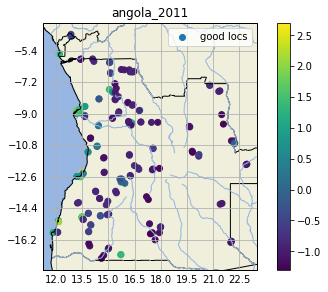

In [10]:
run_processing(country='angola', years=[2011], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_burkina_faso_dhslocs_ee_export.tfrecord.gz
Finished validating 541 records: 541 good, 0 bad


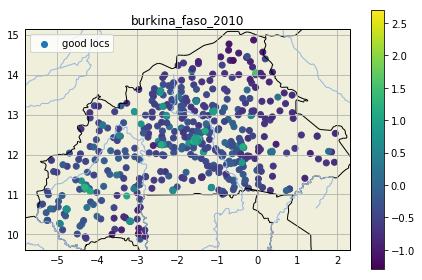

In [11]:
run_processing(country='burkina_faso', years=[2010], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_cameroon_dhslocs_ee_export.tfrecord.gz
Record 142 missing required keys: ['BLUE', 'GREEN', 'LAT', 'LON', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'TEMP1']
  cluster_index: 260
  year: 2011
  lon: 9.730645179748535
Finished validating 577 records: 576 good, 1 bad
Bad locs
     cluster_index  wealthpooled       lat       lon
258          260.0      1.598924  4.035155  9.730645


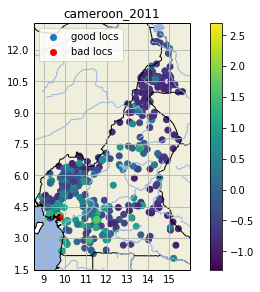

In [12]:
run_processing(country='cameroon', years=[2011], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_ethiopia_dhslocs_ee_export.tfrecord.gz
Finished validating 571 records: 571 good, 0 bad


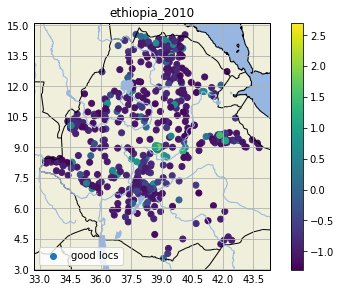

In [13]:
run_processing(country='ethiopia', years=[2010], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_lesotho_dhslocs_ee_export.tfrecord.gz
Finished validating 395 records: 395 good, 0 bad


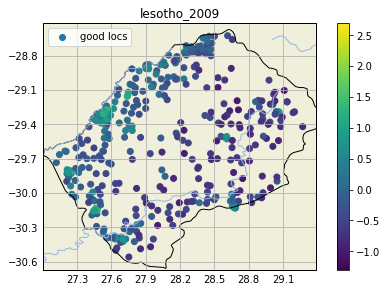

In [14]:
run_processing(country='lesotho', years=[2009], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_malawi_dhslocs_ee_export.tfrecord.gz
Finished validating 827 records: 827 good, 0 bad


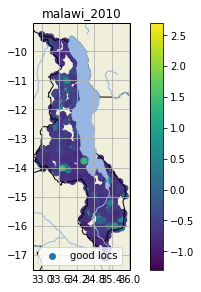

In [15]:
run_processing(country='malawi', years=[2010], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_mozambique_dhslocs_ee_export.tfrecord.gz
Record 155 contains negative bands: ['SWIR2']
  Band 'SWIR2' - count: 1, min value: -9.999999747378752e-05
  cluster_index: 115
  year: 2011
  lon: 39.928287506103516
Finished validating 879 records: 879 good, 0 bad


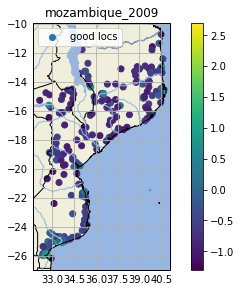

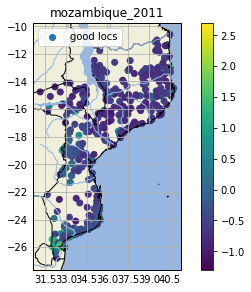

In [16]:
run_processing(country='mozambique', years=[2009, 2011], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_nigeria_dhslocs_ee_export.tfrecord.gz
Record 145 contains negative bands: ['SWIR2']
  Band 'SWIR2' - count: 2, min value: -0.003100000089034438
  cluster_index: 176
  year: 2010
  lon: 8.109100341796875
Finished validating 239 records: 239 good, 0 bad


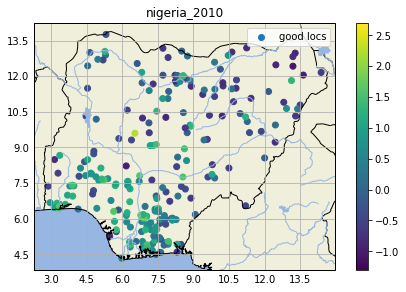

In [17]:
run_processing(country='nigeria', years=[2010], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_rwanda_dhslocs_ee_export.tfrecord.gz
Finished validating 492 records: 492 good, 0 bad


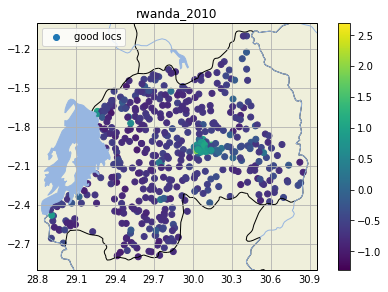

In [18]:
run_processing(country='rwanda', years=[2010], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_senegal_dhslocs_ee_export.tfrecord.gz
Finished validating 385 records: 385 good, 0 bad


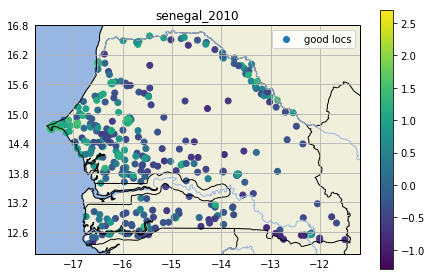

In [19]:
run_processing(country='senegal', years=[2010], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_tanzania_dhslocs_ee_export.tfrecord.gz
Record 377 contains negative bands: ['SWIR2']
  Band 'SWIR2' - count: 1, min value: -0.00019999999494757503
  cluster_index: 90
  year: 2010
  lon: 37.60082244873047
Record 533 contains negative bands: ['BLUE']
  Band 'BLUE' - count: 3, min value: -0.007000000216066837
  cluster_index: 108
  year: 2010
  lon: 39.70244598388672
Finished validating 1031 records: 1031 good, 0 bad


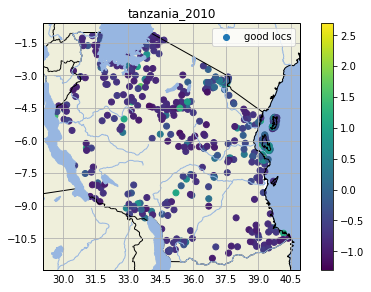

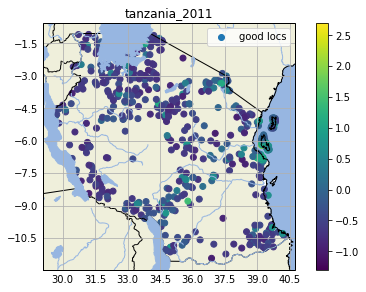

In [20]:
run_processing(country='tanzania', years=[2010, 2011], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_uganda_dhslocs_ee_export.tfrecord.gz
Finished validating 570 records: 570 good, 0 bad


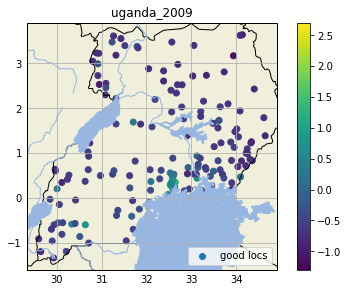

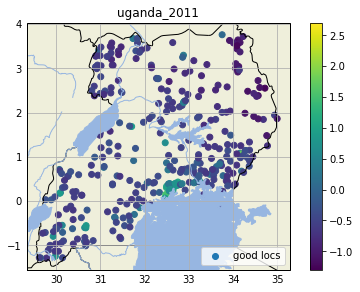

In [21]:
run_processing(country='uganda', years=[2009, 2011], year_range='2009-11')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2009-11_zimbabwe_dhslocs_ee_export.tfrecord.gz
Record 203 contains negative bands: ['SWIR2']
  Band 'SWIR2' - count: 1, min value: -9.999999747378752e-05
  cluster_index: 311
  year: 2010
  lon: 28.84627342224121
Finished validating 393 records: 393 good, 0 bad


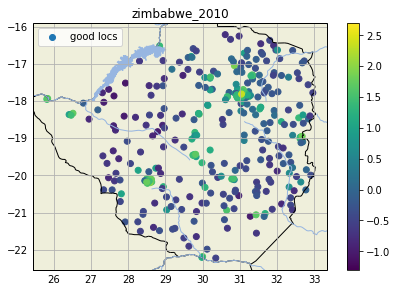

In [22]:
run_processing(country='zimbabwe', years=[2010], year_range='2009-11')

### 2012 - 2014

In [23]:
# for country, years in COUNTRIES_TO_YEARS_2012_14.items():
#     run_processing(country, years, year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_benin_dhslocs_ee_export.tfrecord.gz
Record 95 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7645, min value: -0.044379107654094696
  cluster_index: 157
  year: 2012
  lon: 2.012418508529663
Record 96 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11000, min value: -0.053263887763023376
  cluster_index: 518
  year: 2012
  lon: 1.9488897323608398
Record 97 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2449, min value: -0.012743249535560608
  cluster_index: 143
  year: 2012
  lon: 1.9775211811065674
Record 101 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3245, min value: -0.025218065828084946
  cluster_index: 519
  year: 2012
  lon: 1.8842647075653076
Record 102 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 387, min value: -0.009919257834553719
  cluster_index: 515
  year: 2012
  lon: 1.8367321491241455
Rec

Record 184 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2972, min value: -0.0060515315271914005
  cluster_index: 144
  year: 2012
  lon: 2.03716778755188
Record 185 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 645, min value: -0.00628696708008647
  cluster_index: 145
  year: 2012
  lon: 1.9967485666275024
Record 186 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.0061989473178982735
  cluster_index: 146
  year: 2012
  lon: 2.015497922897339
Record 187 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 225, min value: -0.01921318843960762
  cluster_index: 142
  year: 2012
  lon: 2.035205841064453
Record 189 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 225, min value: -0.01921318843960762
  cluster_index: 148
  year: 2012
  lon: 2.0256474018096924
Record 190 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -7.064

Record 270 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1906, min value: -0.017901461571455002
  cluster_index: 346
  year: 2012
  lon: 1.8437097072601318
Record 271 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1742, min value: -0.016479745507240295
  cluster_index: 347
  year: 2012
  lon: 1.8555328845977783
Record 272 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1680, min value: -0.010943726636469364
  cluster_index: 363
  year: 2012
  lon: 1.868121862411499
Record 273 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 320, min value: -0.009612834081053734
  cluster_index: 366
  year: 2012
  lon: 1.8355343341827393
Record 274 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 225, min value: -0.0024982518516480923
  cluster_index: 368
  year: 2012
  lon: 1.8640729188919067
Record 275 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 315, min value:

Record 346 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2727, min value: -0.018598422408103943
  cluster_index: 275
  year: 2012
  lon: 2.275193691253662
Record 347 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13629, min value: -0.04201986640691757
  cluster_index: 272
  year: 2012
  lon: 2.273113965988159
Record 348 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11896, min value: -0.04201986640691757
  cluster_index: 274
  year: 2012
  lon: 2.2603163719177246
Record 349 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4711, min value: -0.03393641114234924
  cluster_index: 273
  year: 2012
  lon: 2.209399700164795
Record 350 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4208, min value: -0.01828138902783394
  cluster_index: 276
  year: 2012
  lon: 2.189300775527954
Record 351 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10591, min value: -

Record 401 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1632, min value: -0.02326861582696438
  cluster_index: 48
  year: 2012
  lon: 1.2890629768371582
Record 403 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 932, min value: -0.0035611449275165796
  cluster_index: 101
  year: 2012
  lon: 1.2661648988723755
Record 404 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.0035611449275165796
  cluster_index: 98
  year: 2012
  lon: 1.2390947341918945
Record 405 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 366, min value: -0.0009124091011472046
  cluster_index: 93
  year: 2012
  lon: 1.2814491987228394
Record 406 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1580, min value: -0.025266112759709358
  cluster_index: 95
  year: 2012
  lon: 1.3231217861175537
Record 407 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1953, min value: -

Record 452 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6253, min value: -0.03975944593548775
  cluster_index: 305
  year: 2012
  lon: 1.6806883811950684
Record 453 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13900, min value: -0.03479990363121033
  cluster_index: 309
  year: 2012
  lon: 1.7822273969650269
Record 454 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1641, min value: -0.011360002681612968
  cluster_index: 308
  year: 2012
  lon: 1.9621591567993164
Record 455 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.005636341869831085
  cluster_index: 299
  year: 2012
  lon: 1.9708422422409058
Record 456 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 52, min value: -0.004472046624869108
  cluster_index: 297
  year: 2012
  lon: 1.9849908351898193
Record 457 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5982, min value: 

Record 499 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 288, min value: -0.004189605824649334
  cluster_index: 249
  year: 2012
  lon: 2.593381404876709
Record 500 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.004189605824649334
  cluster_index: 251
  year: 2012
  lon: 2.6244378089904785
Record 501 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.005686228629201651
  cluster_index: 256
  year: 2012
  lon: 2.5868775844573975
Record 502 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.005686228629201651
  cluster_index: 257
  year: 2012
  lon: 2.5768370628356934
Record 508 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 282, min value: -0.03406590223312378
  cluster_index: 216
  year: 2012
  lon: 2.658690929412842
Record 518 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2798, min value: -0.0

Record 559 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2736, min value: -0.02904229797422886
  cluster_index: 643
  year: 2012
  lon: 2.587893009185791
Record 560 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1338, min value: -0.021017562597990036
  cluster_index: 659
  year: 2012
  lon: 2.6186091899871826
Record 561 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1201, min value: -0.024113992229104042
  cluster_index: 723
  year: 2012
  lon: 2.4927775859832764
Record 562 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1170, min value: -0.017314907163381577
  cluster_index: 720
  year: 2012
  lon: 2.5037598609924316
Record 563 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2375, min value: -0.020459230989217758
  cluster_index: 626
  year: 2012
  lon: 2.5775485038757324
Record 565 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value:

Record 698 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4665, min value: -0.03583129495382309
  cluster_index: 41
  year: 2012
  lon: 3.6751577854156494
Record 699 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4293, min value: -0.020526733249425888
  cluster_index: 40
  year: 2012
  lon: 3.643148422241211
Record 700 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4163, min value: -0.0330732986330986
  cluster_index: 43
  year: 2012
  lon: 3.4338395595550537
Record 701 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3906, min value: -0.01948515512049198
  cluster_index: 42
  year: 2012
  lon: 3.5220351219177246
Record 702 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8238, min value: -0.035504911094903946
  cluster_index: 22
  year: 2012
  lon: 3.1267056465148926
Record 703 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 24172, min value: -0.03

Finished validating 746 records: 746 good, 0 bad


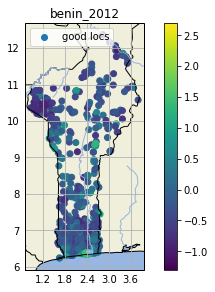

In [24]:
run_processing(country='benin', years=[2012], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_burkina_faso_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.0030557382851839066
  cluster_index: 227
  year: 2014
  lon: -1.6004470586776733
Record 1 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.0018005692400038242
  cluster_index: 190
  year: 2014
  lon: -2.3008840084075928
Record 8 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 608, min value: -0.012335657142102718
  cluster_index: 229
  year: 2014
  lon: -1.7534699440002441
Record 9 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 48, min value: -0.001486501656472683
  cluster_index: 226
  year: 2014
  lon: -1.629202961921692
Record 11 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 225, min value: -0.0011365528916940093
  cluster_index: 85
  year: 2014
  lon: -0.603630006313324
Re

Record 61 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1082, min value: -0.013286426663398743
  cluster_index: 61
  year: 2014
  lon: -0.36796000599861145
Record 62 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2209, min value: -0.017421413213014603
  cluster_index: 68
  year: 2014
  lon: -0.5611510276794434
Record 63 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 375, min value: -0.010787957347929478
  cluster_index: 67
  year: 2014
  lon: -0.6088460087776184
Record 64 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4008, min value: -0.0325353667140007
  cluster_index: 128
  year: 2014
  lon: -0.8325480222702026
Record 65 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 336, min value: -0.007706104777753353
  cluster_index: 126
  year: 2014
  lon: -1.1899800300598145
Record 67 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1262, min value: -0.

Record 141 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 512, min value: -0.0006174581358209252
  cluster_index: 10
  year: 2014
  lon: -2.594027042388916
Record 142 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6984, min value: -0.015540463849902153
  cluster_index: 106
  year: 2014
  lon: -2.512087106704712
Record 143 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1486, min value: -0.007790659088641405
  cluster_index: 11
  year: 2014
  lon: -2.755094051361084
Record 144 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 416, min value: -0.003415773157030344
  cluster_index: 192
  year: 2014
  lon: -2.632801055908203
Record 145 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 271, min value: -0.003189855022355914
  cluster_index: 12
  year: 2014
  lon: -3.0636470317840576
Record 146 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -

Record 206 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0010201577097177505
  cluster_index: 35
  year: 2014
  lon: -5.181944847106934
Record 207 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 728, min value: -0.014192071743309498
  cluster_index: 28
  year: 2014
  lon: -4.9281768798828125
Record 208 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1441, min value: -0.007703274022787809
  cluster_index: 33
  year: 2014
  lon: -4.996774196624756
Record 209 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3137, min value: -0.025769010186195374
  cluster_index: 27
  year: 2014
  lon: -4.858466148376465
Record 210 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4544, min value: -0.01795455999672413
  cluster_index: 29
  year: 2014
  lon: -4.670307159423828
Record 211 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1578, min value: -0

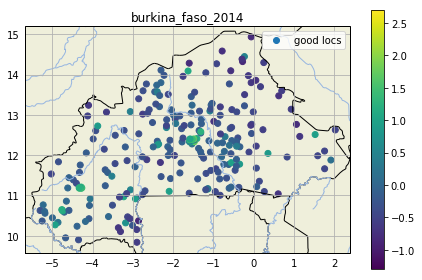

In [25]:
run_processing(country='burkina_faso', years=[2014], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_cote_d_ivoire_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12885, min value: -0.04550154134631157
  cluster_index: 14
  year: 2012
  lon: -6.404806137084961
Record 7 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1457, min value: -0.021546991541981697
  cluster_index: 246
  year: 2012
  lon: -6.705007076263428
Record 10 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1141, min value: -0.008219336159527302
  cluster_index: 159
  year: 2012
  lon: -7.361568927764893
Record 24 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 105, min value: -0.00034888042137026787
  cluster_index: 170
  year: 2012
  lon: -7.8537678718566895
Record 25 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2450, min value: -0.009768789634108543
  cluster_index: 216
  year: 2012
  lon: -8.1665792465209

Record 242 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.008267082273960114
  cluster_index: 90
  year: 2012
  lon: -3.373292922973633
Record 248 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.003627112600952387
  cluster_index: 223
  year: 2012
  lon: -3.6158840656280518
Record 258 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.005179484374821186
  cluster_index: 306
  year: 2012
  lon: -3.73219895362854
Record 266 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3802, min value: -0.018499840050935745
  cluster_index: 133
  year: 2012
  lon: -3.067030906677246
Record 268 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 176, min value: -0.003883402794599533
  cluster_index: 4
  year: 2012
  lon: -3.059561014175415
Record 269 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 272, min value: -0.0

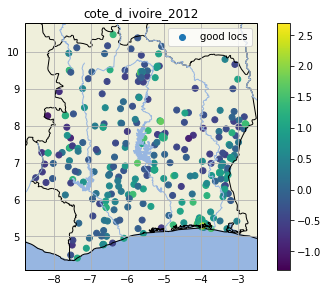

In [26]:
run_processing(country='cote_d_ivoire', years=[2012], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_democratic_republic_of_congo_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3829, min value: -0.030034566298127174
  cluster_index: 466
  year: 2013
  lon: 18.08853530883789
Record 1 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7819, min value: -0.03395853564143181
  cluster_index: 415
  year: 2013
  lon: 19.113798141479492
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1959, min value: -0.021223828196525574
  cluster_index: 143
  year: 2013
  lon: 18.568950653076172
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2678, min value: -0.05512169748544693
  cluster_index: 76
  year: 2013
  lon: 18.55560874938965
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1269, min value: -0.016228262335062027
  cluster_index: 155
  year: 2013
  lon: 18.2744579

Record 45 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4406, min value: -0.02050233632326126
  cluster_index: 202
  year: 2013
  lon: 18.899532318115234
Record 46 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 20711, min value: -0.04305700585246086
  cluster_index: 434
  year: 2013
  lon: 18.985597610473633
Record 47 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 31649, min value: -0.05601504445075989
  cluster_index: 212
  year: 2013
  lon: 18.700870513916016
Record 48 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 19895, min value: -0.051886823028326035
  cluster_index: 477
  year: 2013
  lon: 19.223003387451172
Record 49 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 51859, min value: -0.06528046727180481
  cluster_index: 357
  year: 2013
  lon: 27.541831970214844
Record 50 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 56600, min value: -

Record 94 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 35095, min value: -0.06931131333112717
  cluster_index: 417
  year: 2013
  lon: 29.513774871826172
Record 95 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1129, min value: -0.02890850231051445
  cluster_index: 500
  year: 2013
  lon: 29.474878311157227
Record 96 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2367, min value: -0.02485700510442257
  cluster_index: 121
  year: 2013
  lon: 29.475101470947266
Record 97 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 405, min value: -0.012832721695303917
  cluster_index: 392
  year: 2013
  lon: 30.250097274780273
Record 98 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 50723, min value: -0.07443338632583618
  cluster_index: 229
  year: 2013
  lon: 30.460399627685547
Record 99 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 46759, min value: -0.0

Record 152 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7522, min value: -0.03633403033018112
  cluster_index: 228
  year: 2013
  lon: 23.49712562561035
Record 153 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5762, min value: -0.02522800676524639
  cluster_index: 496
  year: 2013
  lon: 23.95216178894043
Record 154 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 22662, min value: -0.04898061603307724
  cluster_index: 137
  year: 2013
  lon: 22.63496971130371
Record 155 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4503, min value: -0.04551296681165695
  cluster_index: 107
  year: 2013
  lon: 23.455392837524414
Record 156 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6904, min value: -0.04551296681165695
  cluster_index: 446
  year: 2013
  lon: 23.437198638916016
Record 157 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2196, min value: -0.

Record 208 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3678, min value: -0.015810083597898483
  cluster_index: 292
  year: 2013
  lon: 28.0626277923584
Record 209 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10186, min value: -0.02989283576607704
  cluster_index: 265
  year: 2013
  lon: 28.027841567993164
Record 210 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0013525077374652028
  cluster_index: 324
  year: 2013
  lon: 27.561893463134766
Record 211 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 285, min value: -0.005731034092605114
  cluster_index: 502
  year: 2013
  lon: 27.36516761779785
Record 213 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6557, min value: -0.016000790521502495
  cluster_index: 152
  year: 2013
  lon: 26.751028060913086
Record 214 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4310, min value: 

Record 265 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 401, min value: -0.00810276623815298
  cluster_index: 395
  year: 2013
  lon: 28.212556838989258
Record 268 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 9431, min value: -0.051919229328632355
  cluster_index: 383
  year: 2013
  lon: 27.298870086669922
Record 269 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4902, min value: -0.053350165486335754
  cluster_index: 178
  year: 2013
  lon: 27.258285522460938
Record 270 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8456, min value: -0.046918436884880066
  cluster_index: 171
  year: 2013
  lon: 28.2857666015625
Record 271 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3452, min value: -0.03856280818581581
  cluster_index: 275
  year: 2013
  lon: 28.6556396484375
Record 272 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1324, min value: -0.

Record 315 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1378, min value: -0.011621382087469101
  cluster_index: 97
  year: 2013
  lon: 20.88819122314453
Record 316 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 9185, min value: -0.021248482167720795
  cluster_index: 48
  year: 2013
  lon: 19.10858726501465
Record 317 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8834, min value: -0.028448820114135742
  cluster_index: 53
  year: 2013
  lon: 18.747339248657227
Record 318 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1520, min value: -0.007344407495111227
  cluster_index: 285
  year: 2013
  lon: 18.135530471801758
Record 319 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1852, min value: -0.01415305957198143
  cluster_index: 297
  year: 2013
  lon: 18.122209548950195
Record 320 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 450, min value: -0.

Record 363 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 14463, min value: -0.029227998107671738
  cluster_index: 329
  year: 2013
  lon: 22.592063903808594
Record 364 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13137, min value: -0.01974213682115078
  cluster_index: 8
  year: 2013
  lon: 22.101688385009766
Record 365 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12029, min value: -0.02609921433031559
  cluster_index: 475
  year: 2013
  lon: 22.16582679748535
Record 366 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4742, min value: -0.028247393667697906
  cluster_index: 91
  year: 2013
  lon: 22.38199234008789
Record 367 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 169, min value: -0.015338249504566193
  cluster_index: 187
  year: 2013
  lon: 22.40679931640625
Record 368 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4105, min value: -0

Record 410 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12250, min value: -0.03438916057348251
  cluster_index: 114
  year: 2013
  lon: 18.94255256652832
Record 411 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12642, min value: -0.05467291176319122
  cluster_index: 108
  year: 2013
  lon: 19.487499237060547
Record 412 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8239, min value: -0.02236131578683853
  cluster_index: 20
  year: 2013
  lon: 18.8129825592041
Record 413 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13657, min value: -0.023502344265580177
  cluster_index: 70
  year: 2013
  lon: 18.746431350708008
Record 414 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4713, min value: -0.02533644810318947
  cluster_index: 517
  year: 2013
  lon: 18.807029724121094
Record 415 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1426, min value: -0

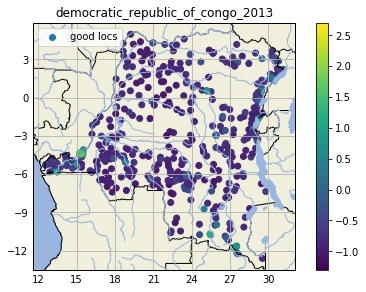

In [27]:
run_processing(country='democratic_republic_of_congo', years=[2013], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_ghana_dhslocs_ee_export.tfrecord.gz
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5043, min value: -0.027043119072914124
  cluster_index: 44
  year: 2014
  lon: -0.06930600106716156
Record 5 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2406, min value: -0.03057388961315155
  cluster_index: 355
  year: 2014
  lon: -0.10648699849843979
Record 6 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1349, min value: -0.0076761008240282536
  cluster_index: 20
  year: 2014
  lon: -0.19080300629138947
Record 7 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3113, min value: -0.02161838673055172
  cluster_index: 343
  year: 2014
  lon: -0.2743690013885498
Record 8 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1517, min value: -0.0055900574661791325
  cluster_index: 312
  year: 2014
  lon: -0.33585599064826965
Re

Record 94 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.014048848301172256
  cluster_index: 133
  year: 2014
  lon: -2.093907117843628
Record 95 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 721, min value: -0.0004352349787950516
  cluster_index: 408
  year: 2014
  lon: -1.9323019981384277
Record 98 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2603, min value: -0.01973762921988964
  cluster_index: 200
  year: 2014
  lon: -2.0155088901519775
Record 99 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.004231720231473446
  cluster_index: 350
  year: 2014
  lon: -2.4395899772644043
Record 100 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 180, min value: -0.002515589352697134
  cluster_index: 14
  year: 2014
  lon: -2.419951915740967
Record 101 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5161, min value: -0

Record 405 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.005134691949933767
  cluster_index: 317
  year: 2014
  lon: 0.4043000042438507
Record 406 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 870, min value: -0.009294545277953148
  cluster_index: 283
  year: 2014
  lon: 0.33654600381851196
Record 407 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8845, min value: -0.0528261661529541
  cluster_index: 345
  year: 2014
  lon: 0.2548289895057678
Record 409 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3392, min value: -0.029893411323428154
  cluster_index: 31
  year: 2014
  lon: 0.008697999641299248
Record 410 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13991, min value: -0.03990005701780319
  cluster_index: 297
  year: 2014
  lon: 0.4234730005264282
Record 411 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1798, min value

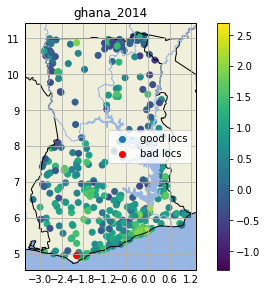

In [28]:
run_processing(country='ghana', years=[2014], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_guinea_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.005398424342274666
  cluster_index: 250
  year: 2012
  lon: -8.809148788452148
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0008897928055375814
  cluster_index: 152
  year: 2012
  lon: -8.65010929107666
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 96, min value: -0.0002567520714364946
  cluster_index: 232
  year: 2012
  lon: -9.07852554321289
Record 5 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 737, min value: -0.00498689291998744
  cluster_index: 284
  year: 2012
  lon: -8.864394187927246
Record 7 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 736, min value: -0.003529731184244156
  cluster_index: 71
  year: 2012
  lon: -9.178175926208496
Record 10 contai

Record 83 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 224, min value: -0.0024152924306690693
  cluster_index: 268
  year: 2012
  lon: -12.686747550964355
Record 86 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 768, min value: -0.006448891945183277
  cluster_index: 139
  year: 2012
  lon: -12.676647186279297
Record 88 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 721, min value: -0.027572905644774437
  cluster_index: 231
  year: 2012
  lon: -12.438353538513184
Record 89 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 510, min value: -0.005648104939609766
  cluster_index: 258
  year: 2012
  lon: -12.547958374023438
Record 90 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.027714086696505547
  cluster_index: 220
  year: 2012
  lon: -12.981633186340332
Record 91 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 752, min value: -0

Record 250 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.012271462939679623
  cluster_index: 110
  year: 2012
  lon: -10.581308364868164
Record 252 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.0035867802798748016
  cluster_index: 223
  year: 2012
  lon: -10.437272071838379
Record 253 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 705, min value: -0.00891563668847084
  cluster_index: 193
  year: 2012
  lon: -10.115544319152832
Record 254 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 176, min value: -0.005106689408421516
  cluster_index: 5
  year: 2012
  lon: -10.10009765625
Record 256 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 903, min value: -0.008102198131382465
  cluster_index: 235
  year: 2012
  lon: -10.109801292419434
Record 257 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.

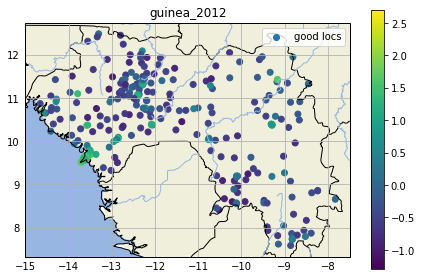

In [29]:
run_processing(country='guinea', years=[2012], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_kenya_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 32319, min value: -0.06548015773296356
  cluster_index: 1031
  year: 2014
  lon: 34.349822998046875
Record 1 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 35467, min value: -0.07386018335819244
  cluster_index: 1032
  year: 2014
  lon: 34.33469772338867
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.005187267437577248
  cluster_index: 1577
  year: 2014
  lon: 34.48454666137695
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2170, min value: -0.031866542994976044
  cluster_index: 1573
  year: 2014
  lon: 34.442203521728516
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 855, min value: -0.01697971671819687
  cluster_index: 1553
  year: 2014
  lon: 34.476131439208984
Record 5 

Record 49 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 9987, min value: -0.040352288633584976
  cluster_index: 1604
  year: 2014
  lon: 33.97187805175781
Record 50 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8250, min value: -0.040352288633584976
  cluster_index: 1603
  year: 2014
  lon: 33.97426986694336
Record 51 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5142, min value: -0.04367706924676895
  cluster_index: 1606
  year: 2014
  lon: 34.006717681884766
Record 52 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1464, min value: -0.023025615140795708
  cluster_index: 807
  year: 2014
  lon: 34.30612564086914
Record 53 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1473, min value: -0.027261637151241302
  cluster_index: 806
  year: 2014
  lon: 34.295318603515625
Record 54 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2479, min value: -0.

Record 146 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2132, min value: -0.027363242581486702
  cluster_index: 1270
  year: 2014
  lon: 35.34062576293945
Record 150 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 992, min value: -0.015782034024596214
  cluster_index: 1196
  year: 2014
  lon: 35.325599670410156
Record 151 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1222, min value: -0.030483514070510864
  cluster_index: 1197
  year: 2014
  lon: 35.430667877197266
Record 152 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1185, min value: -0.0153725640848279
  cluster_index: 1198
  year: 2014
  lon: 35.4039306640625
Record 153 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1144, min value: -0.011656554415822029
  cluster_index: 1237
  year: 2014
  lon: 35.55445098876953
Record 155 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 736, min value:

Record 213 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8336, min value: -0.03145292028784752
  cluster_index: 1235
  year: 2014
  lon: 35.55851364135742
Record 214 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3583, min value: -0.020211324095726013
  cluster_index: 1192
  year: 2014
  lon: 35.31193542480469
Record 215 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6626, min value: -0.02999735251069069
  cluster_index: 1176
  year: 2014
  lon: 35.290401458740234
Record 216 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3293, min value: -0.02853867970407009
  cluster_index: 1172
  year: 2014
  lon: 35.227394104003906
Record 217 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3717, min value: -0.0161597803235054
  cluster_index: 1195
  year: 2014
  lon: 35.32240295410156
Record 218 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2586, min value:

Record 272 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6806, min value: -0.03147795796394348
  cluster_index: 1563
  year: 2014
  lon: 34.760318756103516
Record 273 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5748, min value: -0.030484143644571304
  cluster_index: 1123
  year: 2014
  lon: 34.842159271240234
Record 274 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7494, min value: -0.044684022665023804
  cluster_index: 1122
  year: 2014
  lon: 34.84494400024414
Record 275 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10238, min value: -0.044684022665023804
  cluster_index: 1132
  year: 2014
  lon: 34.841712951660156
Record 276 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3115, min value: -0.032591335475444794
  cluster_index: 1131
  year: 2014
  lon: 34.817012786865234
Record 277 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1135, min

Record 334 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11697, min value: -0.03705684840679169
  cluster_index: 1206
  year: 2014
  lon: 35.62125015258789
Record 335 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6290, min value: -0.025705471634864807
  cluster_index: 1208
  year: 2014
  lon: 35.59029006958008
Record 336 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 22681, min value: -0.03992404043674469
  cluster_index: 1220
  year: 2014
  lon: 35.64161682128906
Record 337 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 41127, min value: -0.05366228520870209
  cluster_index: 1080
  year: 2014
  lon: 36.51416015625
Record 338 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 58789, min value: -0.05627249926328659
  cluster_index: 1036
  year: 2014
  lon: 35.98143005371094
Record 339 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 62210, min value

Record 380 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 16113, min value: -0.026545096188783646
  cluster_index: 1170
  year: 2014
  lon: 36.05565643310547
Record 381 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11459, min value: -0.02656663954257965
  cluster_index: 1313
  year: 2014
  lon: 36.15279006958008
Record 382 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3285, min value: -0.018934736028313637
  cluster_index: 1319
  year: 2014
  lon: 36.20392608642578
Record 383 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 928, min value: -0.010481327772140503
  cluster_index: 1291
  year: 2014
  lon: 36.283538818359375
Record 392 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11079, min value: -0.042601846158504486
  cluster_index: 1302
  year: 2014
  lon: 36.329647064208984
Record 393 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1213, min 

Record 448 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 22574, min value: -0.04021476209163666
  cluster_index: 481
  year: 2014
  lon: 38.497562408447266
Record 449 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 32405, min value: -0.04044739156961441
  cluster_index: 486
  year: 2014
  lon: 38.3919792175293
Record 450 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4867, min value: -0.017717959359288216
  cluster_index: 489
  year: 2014
  lon: 38.209922790527344
Record 451 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 270, min value: -0.013529258780181408
  cluster_index: 516
  year: 2014
  lon: 37.98630905151367
Record 452 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0007810696261003613
  cluster_index: 517
  year: 2014
  lon: 38.007938385009766
Record 453 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1456, min value: 

Record 497 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 51475, min value: -0.06489690393209457
  cluster_index: 762
  year: 2014
  lon: 39.260372161865234
Record 498 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 48339, min value: -0.054150111973285675
  cluster_index: 462
  year: 2014
  lon: 38.91555404663086
Record 499 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 54625, min value: -0.07209764420986176
  cluster_index: 459
  year: 2014
  lon: 39.201026916503906
Record 500 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 38049, min value: -0.058575622737407684
  cluster_index: 745
  year: 2014
  lon: 39.761966705322266
Record 501 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 44114, min value: -0.05687877535820007
  cluster_index: 744
  year: 2014
  lon: 39.639381408691406
Record 502 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 46035, min v

Record 543 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 22313, min value: -0.04105012118816376
  cluster_index: 1029
  year: 2014
  lon: 34.87003707885742
Record 544 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12093, min value: -0.045398958027362823
  cluster_index: 1027
  year: 2014
  lon: 34.83924102783203
Record 545 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 60389, min value: -0.06688521802425385
  cluster_index: 1026
  year: 2014
  lon: 34.664093017578125
Record 546 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 53634, min value: -0.05348096042871475
  cluster_index: 1023
  year: 2014
  lon: 35.86153793334961
Record 547 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 58054, min value: -0.07068056613206863
  cluster_index: 1024
  year: 2014
  lon: 35.46116638183594
Record 548 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 64102, min 

Record 593 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 45, min value: -0.00201990338973701
  cluster_index: 749
  year: 2014
  lon: 40.047054290771484
Record 595 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 165, min value: -0.007222711108624935
  cluster_index: 748
  year: 2014
  lon: 40.031925201416016
Record 596 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 364, min value: -0.005038863979279995
  cluster_index: 756
  year: 2014
  lon: 40.05248260498047
Record 597 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 16829, min value: -0.034501418471336365
  cluster_index: 734
  year: 2014
  lon: 40.52573776245117
Record 598 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 26319, min value: -0.034533657133579254
  cluster_index: 735
  year: 2014
  lon: 40.93321990966797
Record 599 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 19342, min value: -

Record 648 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5445, min value: -0.025715665891766548
  cluster_index: 387
  year: 2014
  lon: 40.549903869628906
Record 649 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4474, min value: -0.017080998048186302
  cluster_index: 393
  year: 2014
  lon: 40.36141586303711
Record 650 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4369, min value: -0.01806746982038021
  cluster_index: 357
  year: 2014
  lon: 40.102439880371094
Record 651 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4508, min value: -0.01348334364593029
  cluster_index: 358
  year: 2014
  lon: 39.994441986083984
Record 652 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5605, min value: -0.019176576286554337
  cluster_index: 359
  year: 2014
  lon: 40.155853271484375
Record 653 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10482, min value

Record 750 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 600, min value: -0.02048444002866745
  cluster_index: 652
  year: 2014
  lon: 37.617061614990234
Record 755 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.007267913315445185
  cluster_index: 657
  year: 2014
  lon: 37.44907760620117
Record 756 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 481, min value: -0.013799562118947506
  cluster_index: 653
  year: 2014
  lon: 37.37185287475586
Record 757 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 45, min value: -0.013799562118947506
  cluster_index: 182
  year: 2014
  lon: 37.322731018066406
Record 758 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 752, min value: -0.00644796434789896
  cluster_index: 654
  year: 2014
  lon: 37.34083938598633
Record 759 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1186, min value: -0.0061

Record 831 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.009531943127512932
  cluster_index: 552
  year: 2014
  lon: 37.726165771484375
Record 832 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 93, min value: -0.009531943127512932
  cluster_index: 553
  year: 2014
  lon: 37.7226676940918
Record 836 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.010532284155488014
  cluster_index: 545
  year: 2014
  lon: 37.598793029785156
Record 840 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1500, min value: -0.022127404808998108
  cluster_index: 577
  year: 2014
  lon: 37.55378723144531
Record 857 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8834, min value: -0.038295675069093704
  cluster_index: 512
  year: 2014
  lon: 37.574302673339844
Record 858 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 631, min value: -0.0

Record 1008 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 444, min value: -0.015259986743330956
  cluster_index: 59
  year: 2014
  lon: 36.4730224609375
Record 1009 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 517, min value: -0.010249365121126175
  cluster_index: 63
  year: 2014
  lon: 36.327083587646484
Record 1010 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 481, min value: -0.010249365121126175
  cluster_index: 66
  year: 2014
  lon: 36.33293914794922
Record 1011 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.011729847639799118
  cluster_index: 69
  year: 2014
  lon: 36.25717544555664
Record 1014 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3696, min value: -0.011224978603422642
  cluster_index: 1161
  year: 2014
  lon: 35.789337158203125
Record 1015 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 112, min value: -0

Record 1090 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2899, min value: -0.024601243436336517
  cluster_index: 870
  year: 2014
  lon: 34.976924896240234
Record 1091 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10746, min value: -0.01754947565495968
  cluster_index: 1411
  year: 2014
  lon: 35.068721771240234
Record 1093 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 481, min value: -0.0024643978103995323
  cluster_index: 1421
  year: 2014
  lon: 35.154232025146484
Record 1098 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 368, min value: -0.016537407413125038
  cluster_index: 1439
  year: 2014
  lon: 35.06550598144531
Record 1099 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1170, min value: -0.008300070650875568
  cluster_index: 1438
  year: 2014
  lon: 35.13264846801758
Record 1100 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, m

Record 1207 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1201, min value: -0.010319901630282402
  cluster_index: 1456
  year: 2014
  lon: 35.27423858642578
Record 1208 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 721, min value: -0.008068278431892395
  cluster_index: 1462
  year: 2014
  lon: 35.32246780395508
Record 1209 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.007611700799316168
  cluster_index: 1460
  year: 2014
  lon: 35.33958053588867
Record 1216 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2403, min value: -0.03366103023290634
  cluster_index: 1445
  year: 2014
  lon: 35.371028900146484
Record 1217 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1353, min value: -0.01057082787156105
  cluster_index: 1340
  year: 2014
  lon: 35.641029357910156
Record 1218 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6256, min

Record 1387 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 450, min value: -0.007243012078106403
  cluster_index: 399
  year: 2014
  lon: 38.642940521240234
Record 1388 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.006329888477921486
  cluster_index: 411
  year: 2014
  lon: 38.381954193115234
Record 1393 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1457, min value: -0.015016677789390087
  cluster_index: 416
  year: 2014
  lon: 38.26645278930664
Record 1395 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.0017853905446827412
  cluster_index: 413
  year: 2014
  lon: 38.30442428588867
Record 1396 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.0017853905446827412
  cluster_index: 412
  year: 2014
  lon: 38.32656478881836
Record 1401 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 285, min val

Record 1550 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13897, min value: -0.030274847522377968
  cluster_index: 914
  year: 2014
  lon: 34.29181671142578
Record 1551 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12692, min value: -0.03325079753994942
  cluster_index: 881
  year: 2014
  lon: 34.28790283203125
Record 1552 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3054, min value: -0.02111821249127388
  cluster_index: 882
  year: 2014
  lon: 34.16428756713867
Record 1553 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4270, min value: -0.03021053783595562
  cluster_index: 916
  year: 2014
  lon: 34.35344314575195
Record 1554 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 585, min value: -0.020714398473501205
  cluster_index: 917
  year: 2014
  lon: 34.43754196166992
Record 1555 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 585, min value

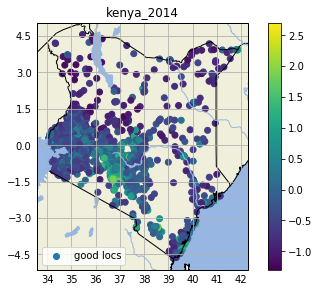

In [30]:
run_processing(country='kenya', years=[2014], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_lesotho_dhslocs_ee_export.tfrecord.gz
Record 345 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 288, min value: -0.0005972106009721756
  cluster_index: 187
  year: 2014
  lon: 28.830785751342773
Finished validating 399 records: 399 good, 0 bad


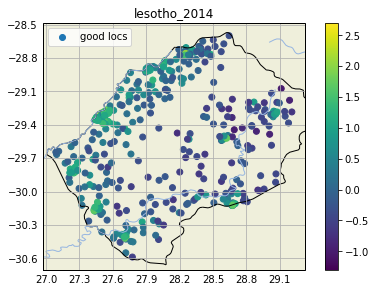

In [31]:
run_processing(country='lesotho', years=[2014], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_malawi_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6877, min value: -0.015102624893188477
  cluster_index: 139
  year: 2012
  lon: 35.093109130859375
Record 1 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1626, min value: -0.02065010368824005
  cluster_index: 124
  year: 2014
  lon: 35.26363754272461
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5663, min value: -0.037314437329769135
  cluster_index: 138
  year: 2012
  lon: 35.28786087036133
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10742, min value: -0.03201751410961151
  cluster_index: 109
  year: 2014
  lon: 35.205745697021484
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1059, min value: -0.00843411311507225
  cluster_index: 120
  year: 2014
  lon: 35.08169174194336
Record 5 cont

Record 104 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.0006058556027710438
  cluster_index: 87
  year: 2012
  lon: 35.133384704589844
Record 105 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5003, min value: -0.012283988296985626
  cluster_index: 91
  year: 2014
  lon: 35.068321228027344
Record 106 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8064, min value: -0.01567055843770504
  cluster_index: 90
  year: 2012
  lon: 35.002140045166016
Record 107 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6108, min value: -0.018260661512613297
  cluster_index: 78
  year: 2012
  lon: 34.76239013671875
Record 109 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6129, min value: -0.021843530237674713
  cluster_index: 77
  year: 2014
  lon: 34.60273742675781
Record 110 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4188, min value: -0.0

Record 152 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 18741, min value: -0.04293570667505264
  cluster_index: 23
  year: 2014
  lon: 33.355445861816406
Record 153 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 23398, min value: -0.029683247208595276
  cluster_index: 22
  year: 2014
  lon: 33.39275360107422
Record 154 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 25332, min value: -0.043759994208812714
  cluster_index: 16
  year: 2012
  lon: 33.35664749145508
Record 155 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 18509, min value: -0.05180567502975464
  cluster_index: 21
  year: 2014
  lon: 33.34998321533203
Record 156 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12695, min value: -0.030959773808717728
  cluster_index: 31
  year: 2014
  lon: 33.365840911865234
Record 157 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 20990, min value: 

Record 205 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10335, min value: -0.02930285781621933
  cluster_index: 65
  year: 2014
  lon: 33.27040481567383
Record 206 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3877, min value: -0.010494906455278397
  cluster_index: 48
  year: 2012
  lon: 33.291961669921875
Record 207 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3616, min value: -0.013341748155653477
  cluster_index: 41
  year: 2012
  lon: 33.60529708862305
Record 208 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10117, min value: -0.016872018575668335
  cluster_index: 37
  year: 2012
  lon: 33.665435791015625
Record 209 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1471, min value: -0.009373905137181282
  cluster_index: 35
  year: 2012
  lon: 33.77577590942383
Record 210 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1376, min value: -0.

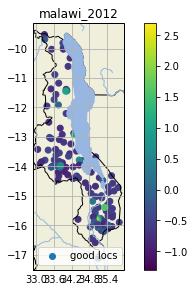

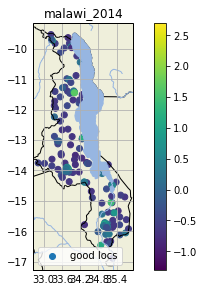

In [32]:
run_processing(country='malawi', years=[2012, 2014], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_mali_dhslocs_ee_export.tfrecord.gz
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1616, min value: -0.017363207414746284
  cluster_index: 337
  year: 2012
  lon: -3.3497769832611084
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1744, min value: -0.00943339429795742
  cluster_index: 243
  year: 2012
  lon: -3.4302940368652344
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5376, min value: -0.024461019784212112
  cluster_index: 88
  year: 2012
  lon: -3.5404560565948486
Record 5 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.0021590222604572773
  cluster_index: 2
  year: 2012
  lon: -3.6605920791625977
Record 6 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.009020633064210415
  cluster_index: 67
  year: 2012
  lon: -4.8845062255859375
Record 7 co

Record 85 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.005845055915415287
  cluster_index: 398
  year: 2012
  lon: -7.315638065338135
Record 86 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.002353882882744074
  cluster_index: 340
  year: 2012
  lon: -7.700563907623291
Record 88 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.002149874111637473
  cluster_index: 78
  year: 2012
  lon: -7.762368202209473
Record 95 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.008134170435369015
  cluster_index: 510
  year: 2012
  lon: -5.843986988067627
Record 98 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 32, min value: -0.0026033641770482063
  cluster_index: 268
  year: 2012
  lon: -6.051685810089111
Record 99 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.013892

Record 176 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.004872099496424198
  cluster_index: 28
  year: 2012
  lon: -6.182758808135986
Record 177 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 379, min value: -0.012966983951628208
  cluster_index: 366
  year: 2012
  lon: -6.256048202514648
Record 178 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 341, min value: -0.015477528795599937
  cluster_index: 319
  year: 2012
  lon: -6.3167338371276855
Record 181 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.009042654186487198
  cluster_index: 317
  year: 2012
  lon: -6.365368843078613
Record 184 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.009546331129968166
  cluster_index: 542
  year: 2012
  lon: -6.966145992279053
Record 186 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 421, min value: -0

Record 361 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5360, min value: -0.024179358035326004
  cluster_index: 310
  year: 2012
  lon: -9.501529693603516
Record 369 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 255, min value: -0.004486504476517439
  cluster_index: 481
  year: 2012
  lon: -8.815478324890137
Record 372 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12, min value: -0.013602210208773613
  cluster_index: 135
  year: 2012
  lon: -9.389348983764648
Record 373 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 992, min value: -0.011549122631549835
  cluster_index: 265
  year: 2012
  lon: -9.661823272705078
Record 378 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 272, min value: -0.011379623785614967
  cluster_index: 119
  year: 2012
  lon: -10.204085350036621
Record 379 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -

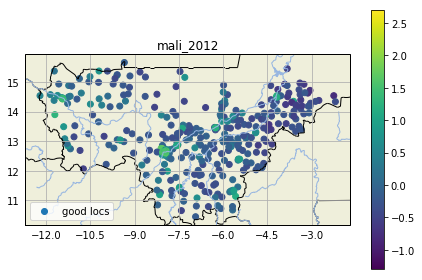

In [33]:
run_processing(country='mali', years=[2012], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_nigeria_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1623, min value: -0.010242524556815624
  cluster_index: 897
  year: 2013
  lon: 3.34053897857666
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8673, min value: -0.03411361947655678
  cluster_index: 883
  year: 2013
  lon: 3.361593008041382
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2965, min value: -0.019822783768177032
  cluster_index: 896
  year: 2013
  lon: 3.4012229442596436
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 849, min value: -0.017211925238370895
  cluster_index: 904
  year: 2013
  lon: 3.412813901901245
Record 5 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1094, min value: -0.013686852529644966
  cluster_index: 901
  year: 2013
  lon: 3.5474491119384766
Record 6 cont

Record 228 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2920, min value: -0.01330005843192339
  cluster_index: 504
  year: 2013
  lon: 7.768628120422363
Record 229 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10170, min value: -0.04083453118801117
  cluster_index: 547
  year: 2013
  lon: 7.7269768714904785
Record 230 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 808, min value: -0.01451743021607399
  cluster_index: 548
  year: 2013
  lon: 7.55788516998291
Record 231 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13946, min value: -0.03737024962902069
  cluster_index: 550
  year: 2013
  lon: 7.751943111419678
Record 232 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1480, min value: -0.017022065818309784
  cluster_index: 555
  year: 2013
  lon: 7.740756988525391
Record 255 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 690, min value: -0.00

Record 329 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3405, min value: -0.031610891222953796
  cluster_index: 764
  year: 2013
  lon: 5.4983978271484375
Record 330 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3091, min value: -0.026661433279514313
  cluster_index: 751
  year: 2013
  lon: 5.5320539474487305
Record 331 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.007893180474638939
  cluster_index: 749
  year: 2013
  lon: 5.41743278503418
Record 335 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1217, min value: -0.014833467081189156
  cluster_index: 757
  year: 2013
  lon: 5.08070182800293
Record 340 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1830, min value: -0.04408804327249527
  cluster_index: 768
  year: 2013
  lon: 5.39141321182251
Record 341 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4924, min value: -0.0

Record 415 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 30635, min value: -0.04219023138284683
  cluster_index: 3
  year: 2013
  lon: 7.940456867218018
Record 416 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11026, min value: -0.0764402225613594
  cluster_index: 111
  year: 2013
  lon: 7.848826885223389
Record 417 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 33563, min value: -0.055048685520887375
  cluster_index: 98
  year: 2013
  lon: 8.356697082519531
Record 419 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 28318, min value: -0.05194012075662613
  cluster_index: 116
  year: 2013
  lon: 8.83373737335205
Record 420 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2018, min value: -0.020372197031974792
  cluster_index: 105
  year: 2013
  lon: 8.620824813842773
Record 421 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 45, min value: -0.0015

Record 470 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 38926, min value: -0.06206858903169632
  cluster_index: 266
  year: 2013
  lon: 9.686684608459473
Record 471 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 33055, min value: -0.05516766756772995
  cluster_index: 22
  year: 2013
  lon: 9.538207054138184
Record 472 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 40455, min value: -0.06901853531599045
  cluster_index: 23
  year: 2013
  lon: 9.621146202087402
Record 473 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 21471, min value: -0.05670314282178879
  cluster_index: 264
  year: 2013
  lon: 9.98908805847168
Record 474 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 35890, min value: -0.05144224315881729
  cluster_index: 279
  year: 2013
  lon: 10.063673973083496
Record 475 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4435, min value: -0.

Record 518 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10331, min value: -0.03462999686598778
  cluster_index: 539
  year: 2013
  lon: 7.953141212463379
Record 519 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10614, min value: -0.038715898990631104
  cluster_index: 556
  year: 2013
  lon: 7.835072040557861
Record 520 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10154, min value: -0.02763858623802662
  cluster_index: 540
  year: 2013
  lon: 8.097766876220703
Record 521 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13541, min value: -0.03661680594086647
  cluster_index: 652
  year: 2013
  lon: 8.0928373336792
Record 522 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 19646, min value: -0.03898559883236885
  cluster_index: 551
  year: 2013
  lon: 7.793280124664307
Record 523 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3758, min value: -0

Record 627 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 28383, min value: -0.04842785745859146
  cluster_index: 185
  year: 2013
  lon: 12.272055625915527
Record 628 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 35720, min value: -0.0551864430308342
  cluster_index: 236
  year: 2013
  lon: 11.966789245605469
Record 629 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7242, min value: -0.02349611185491085
  cluster_index: 259
  year: 2013
  lon: 11.358393669128418
Record 630 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 50992, min value: -0.06414593756198883
  cluster_index: 238
  year: 2013
  lon: 11.486330032348633
Record 631 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 33280, min value: -0.07336483895778656
  cluster_index: 243
  year: 2013
  lon: 11.681512832641602
Record 632 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 31818, min valu

Record 681 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 15011, min value: -0.05141975358128548
  cluster_index: 235
  year: 2013
  lon: 13.051286697387695
Record 682 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1518, min value: -0.014721198007464409
  cluster_index: 232
  year: 2013
  lon: 12.835664749145508
Record 683 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8891, min value: -0.02544252760708332
  cluster_index: 284
  year: 2013
  lon: 11.407463073730469
Record 684 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 18017, min value: -0.025987982749938965
  cluster_index: 283
  year: 2013
  lon: 11.041292190551758
Record 685 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 17761, min value: -0.04546310752630234
  cluster_index: 297
  year: 2013
  lon: 11.027579307556152
Record 686 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 43992, min va

Record 728 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 52405, min value: -0.053808778524398804
  cluster_index: 313
  year: 2013
  lon: 9.910355567932129
Record 729 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 52847, min value: -0.061772577464580536
  cluster_index: 311
  year: 2013
  lon: 10.0105562210083
Record 730 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 20268, min value: -0.050947584211826324
  cluster_index: 203
  year: 2013
  lon: 10.485236167907715
Record 731 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 54224, min value: -0.05442960560321808
  cluster_index: 197
  year: 2013
  lon: 9.63647747039795
Record 732 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 44023, min value: -0.049599677324295044
  cluster_index: 205
  year: 2013
  lon: 9.556173324584961
Record 733 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 49245, min valu

Record 793 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11587, min value: -0.03515785187482834
  cluster_index: 406
  year: 2013
  lon: 7.9799981117248535
Record 794 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4958, min value: -0.02594727836549282
  cluster_index: 407
  year: 2013
  lon: 7.934370040893555
Record 795 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4546, min value: -0.02967800945043564
  cluster_index: 408
  year: 2013
  lon: 8.0186767578125
Record 796 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7366, min value: -0.01535473670810461
  cluster_index: 409
  year: 2013
  lon: 7.919713020324707
Record 799 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5241, min value: -0.024027077481150627
  cluster_index: 395
  year: 2013
  lon: 7.243291854858398
Record 800 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 330, min value: -0.006

Record 850 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1136, min value: -0.02116650715470314
  cluster_index: 462
  year: 2013
  lon: 5.512829780578613
Record 851 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2720, min value: -0.02029567025601864
  cluster_index: 463
  year: 2013
  lon: 5.415383815765381
Record 852 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1996, min value: -0.02029567025601864
  cluster_index: 461
  year: 2013
  lon: 5.449222087860107
Record 853 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 512, min value: -0.013685336336493492
  cluster_index: 443
  year: 2013
  lon: 5.423015117645264
Record 858 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1392, min value: -0.015362636186182499
  cluster_index: 442
  year: 2013
  lon: 5.089259147644043
Record 860 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 721, min value: -0.019

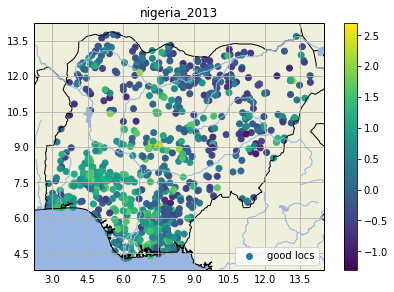

In [34]:
run_processing(country='nigeria', years=[2013], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_rwanda_dhslocs_ee_export.tfrecord.gz
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 225, min value: -0.012075905688107014
  cluster_index: 408
  year: 2014
  lon: 29.037540435791016
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 705, min value: -0.00383104314096272
  cluster_index: 348
  year: 2014
  lon: 28.968826293945312
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.00383104314096272
  cluster_index: 258
  year: 2014
  lon: 28.979801177978516
Record 6 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 150, min value: -0.00383104314096272
  cluster_index: 204
  year: 2014
  lon: 29.012975692749023
Record 11 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1025, min value: -0.004426458850502968
  cluster_index: 280
  year: 2014
  lon: 29.033729553222656
Record 13 cont

Record 74 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4357, min value: -0.033763036131858826
  cluster_index: 316
  year: 2014
  lon: 29.505338668823242
Record 75 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2205, min value: -0.014136631973087788
  cluster_index: 463
  year: 2014
  lon: 29.447084426879883
Record 76 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 975, min value: -0.004401166923344135
  cluster_index: 21
  year: 2014
  lon: 29.469165802001953
Record 77 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1786, min value: -0.014136631973087788
  cluster_index: 245
  year: 2014
  lon: 29.47596549987793
Record 78 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1841, min value: -0.01841612160205841
  cluster_index: 104
  year: 2014
  lon: 29.488529205322266
Record 79 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1209, min value: -0.024

Record 149 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3136, min value: -0.024800550192594528
  cluster_index: 363
  year: 2014
  lon: 30.391300201416016
Record 151 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1235, min value: -0.013539516367018223
  cluster_index: 385
  year: 2014
  lon: 30.45416259765625
Record 152 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2433, min value: -0.02690788358449936
  cluster_index: 283
  year: 2014
  lon: 30.516246795654297
Record 153 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6654, min value: -0.03468427434563637
  cluster_index: 224
  year: 2014
  lon: 30.394039154052734
Record 154 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5231, min value: -0.03468427434563637
  cluster_index: 84
  year: 2014
  lon: 30.383169174194336
Record 155 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1206, min value: -

Record 234 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1056, min value: -0.005693519022315741
  cluster_index: 312
  year: 2014
  lon: 30.285375595092773
Record 235 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 930, min value: -0.0060491785407066345
  cluster_index: 240
  year: 2014
  lon: 30.164621353149414
Record 236 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2118, min value: -0.017926787957549095
  cluster_index: 122
  year: 2014
  lon: 30.212814331054688
Record 237 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3171, min value: -0.018669871613383293
  cluster_index: 51
  year: 2014
  lon: 30.22695541381836
Record 238 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1709, min value: -0.02853744477033615
  cluster_index: 454
  year: 2014
  lon: 30.252519607543945
Record 239 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4872, min value:

Record 292 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1932, min value: -0.01970309019088745
  cluster_index: 187
  year: 2014
  lon: 30.125211715698242
Record 293 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2834, min value: -0.0149458646774292
  cluster_index: 491
  year: 2014
  lon: 30.066869735717773
Record 294 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1813, min value: -0.0149458646774292
  cluster_index: 159
  year: 2014
  lon: 30.029342651367188
Record 295 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 903, min value: -0.013197897002100945
  cluster_index: 149
  year: 2014
  lon: 30.05633544921875
Record 296 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2022, min value: -0.026499910280108452
  cluster_index: 293
  year: 2014
  lon: 29.989534378051758
Record 297 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.0

Record 434 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 481, min value: -0.008549587801098824
  cluster_index: 144
  year: 2014
  lon: 29.69245719909668
Record 437 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 600, min value: -0.005716623738408089
  cluster_index: 243
  year: 2014
  lon: 29.7657413482666
Record 438 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2019, min value: -0.015428573824465275
  cluster_index: 239
  year: 2014
  lon: 29.767955780029297
Record 439 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 390, min value: -0.014823023229837418
  cluster_index: 356
  year: 2014
  lon: 29.64238166809082
Record 440 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 690, min value: -0.014823023229837418
  cluster_index: 449
  year: 2014
  lon: 29.613466262817383
Record 441 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.00

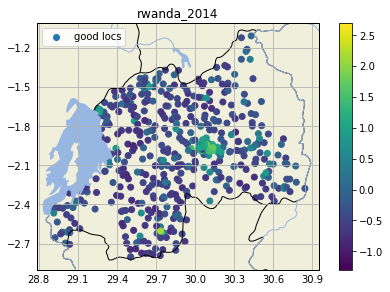

In [35]:
run_processing(country='rwanda', years=[2014], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_senegal_dhslocs_ee_export.tfrecord.gz
Record 55 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.005563803017139435
  cluster_index: 189
  year: 2012
  lon: -16.72826385498047
Record 56 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.00873908307403326
  cluster_index: 191
  year: 2012
  lon: -16.57240867614746
Record 57 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 304, min value: -0.003973752725869417
  cluster_index: 194
  year: 2012
  lon: -16.66286849975586
Record 69 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 208, min value: -0.006598170846700668
  cluster_index: 150
  year: 2012
  lon: -15.299646377563477
Record 70 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.00043643757817335427
  cluster_index: 147
  year: 2012
  lon: -15.288572311401367
Reco

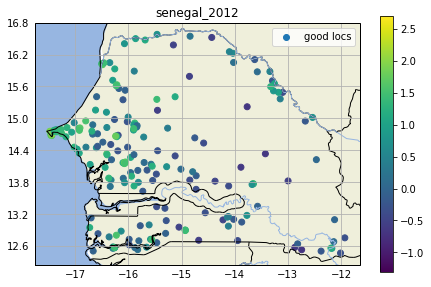

In [36]:
run_processing(country='senegal', years=[2012], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_sierra_leone_dhslocs_ee_export.tfrecord.gz
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.009510187432169914
  cluster_index: 82
  year: 2013
  lon: -10.97025203704834
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 992, min value: -0.008217515423893929
  cluster_index: 108
  year: 2013
  lon: -10.907282829284668
Record 5 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 562, min value: -0.0048762112855911255
  cluster_index: 149
  year: 2013
  lon: -11.12617015838623
Record 9 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0018260630313307047
  cluster_index: 244
  year: 2013
  lon: -10.998143196105957
Record 17 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1651, min value: -0.011254155077040195
  cluster_index: 136
  year: 2013
  lon: -11.489998817443848
R

Record 117 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 675, min value: -0.010133592411875725
  cluster_index: 336
  year: 2013
  lon: -13.011809349060059
Record 118 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2717, min value: -0.015410594642162323
  cluster_index: 340
  year: 2013
  lon: -13.085165023803711
Record 119 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1489, min value: -0.028562352061271667
  cluster_index: 48
  year: 2013
  lon: -13.194625854492188
Record 120 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 368, min value: -0.0011415514163672924
  cluster_index: 205
  year: 2013
  lon: -13.215476036071777
Record 121 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0011415514163672924
  cluster_index: 35
  year: 2013
  lon: -13.232744216918945
Record 160 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min va

Record 303 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 16, min value: -0.011342399753630161
  cluster_index: 32
  year: 2013
  lon: -11.24853801727295
Record 306 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 176, min value: -0.03277316689491272
  cluster_index: 111
  year: 2013
  lon: -11.283018112182617
Record 307 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1008, min value: -0.005609437823295593
  cluster_index: 242
  year: 2013
  lon: -11.014354705810547
Record 308 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1137, min value: -0.017031339928507805
  cluster_index: 198
  year: 2013
  lon: -11.006025314331055
Record 309 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 930, min value: -0.03512156009674072
  cluster_index: 10
  year: 2013
  lon: -11.066643714904785
Record 310 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 976, min value: -

Record 406 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.008495589718222618
  cluster_index: 11
  year: 2013
  lon: -11.510641098022461
Record 407 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5640, min value: -0.033556170761585236
  cluster_index: 78
  year: 2013
  lon: -11.511937141418457
Record 409 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13, min value: -0.008969435468316078
  cluster_index: 72
  year: 2013
  lon: -12.217245101928711
Record 410 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.021671537309885025
  cluster_index: 318
  year: 2013
  lon: -12.1133394241333
Record 413 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 450, min value: -0.001920180395245552
  cluster_index: 267
  year: 2013
  lon: -12.097779273986816
Record 414 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0

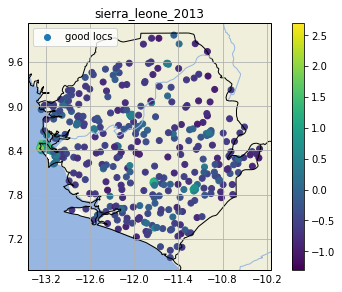

In [37]:
run_processing(country='sierra_leone', years=[2013], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_togo_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 225, min value: -0.0006745234713889658
  cluster_index: 300
  year: 2013
  lon: 0.9797350168228149
Record 37 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 323, min value: -0.011399546638131142
  cluster_index: 278
  year: 2013
  lon: 1.76426100730896
Record 38 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 946, min value: -0.01199889462441206
  cluster_index: 98
  year: 2013
  lon: 1.7186449766159058
Record 40 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 496, min value: -0.004437035880982876
  cluster_index: 235
  year: 2013
  lon: 1.565282940864563
Record 41 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.004437035880982876
  cluster_index: 229
  year: 2013
  lon: 1.5237330198287964
Record 108 cont

Record 162 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5405, min value: -0.030409645289182663
  cluster_index: 289
  year: 2013
  lon: 1.1812570095062256
Record 163 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8016, min value: -0.037059955298900604
  cluster_index: 165
  year: 2013
  lon: 1.1726540327072144
Record 165 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5377, min value: -0.028195668011903763
  cluster_index: 151
  year: 2013
  lon: 1.1335389614105225
Record 166 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 9599, min value: -0.04344239830970764
  cluster_index: 288
  year: 2013
  lon: 1.0229569673538208
Record 167 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 376, min value: -0.001467750407755375
  cluster_index: 277
  year: 2013
  lon: 0.9133780002593994
Record 168 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13516, min valu

Record 222 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2974, min value: -0.026193279772996902
  cluster_index: 124
  year: 2013
  lon: 0.5784369707107544
Record 223 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8863, min value: -0.030576806515455246
  cluster_index: 80
  year: 2013
  lon: 0.45707499980926514
Record 224 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 705, min value: -0.01828543096780777
  cluster_index: 131
  year: 2013
  lon: 0.07345999777317047
Record 225 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0029384703375399113
  cluster_index: 146
  year: 2013
  lon: 0.13408499956130981
Record 226 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2375, min value: -0.021813232451677322
  cluster_index: 262
  year: 2013
  lon: 0.19850200414657593
Record 227 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2714, min va

Record 293 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10917, min value: -0.022963840514421463
  cluster_index: 307
  year: 2013
  lon: 0.7824519872665405
Record 294 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4436, min value: -0.018802303820848465
  cluster_index: 220
  year: 2013
  lon: 0.6935129761695862
Record 295 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3849, min value: -0.02105056867003441
  cluster_index: 55
  year: 2013
  lon: 0.7165809869766235
Record 296 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3001, min value: -0.015526331029832363
  cluster_index: 231
  year: 2013
  lon: 0.6038939952850342
Record 297 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2913, min value: -0.014466487802565098
  cluster_index: 42
  year: 2013
  lon: 0.5793750286102295
Record 298 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2366, min value

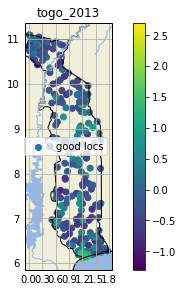

In [38]:
run_processing(country='togo', years=[2013], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_uganda_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 19961, min value: -0.06513100862503052
  cluster_index: 169
  year: 2014
  lon: 30.058181762695312
Record 1 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 18593, min value: -0.08198782801628113
  cluster_index: 177
  year: 2014
  lon: 30.12812042236328
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6338, min value: -0.03875650465488434
  cluster_index: 179
  year: 2014
  lon: 29.741910934448242
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.003650604048743844
  cluster_index: 180
  year: 2014
  lon: 29.763153076171875
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2292, min value: -0.012006809934973717
  cluster_index: 181
  year: 2014
  lon: 29.850177764892578
Record 5 co

Record 45 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 22338, min value: -0.05756707116961479
  cluster_index: 157
  year: 2014
  lon: 32.68467330932617
Record 46 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 23967, min value: -0.055254511535167694
  cluster_index: 151
  year: 2014
  lon: 32.61428451538086
Record 47 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 25950, min value: -0.05327587574720383
  cluster_index: 150
  year: 2014
  lon: 32.53986740112305
Record 48 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 26653, min value: -0.048568494617938995
  cluster_index: 152
  year: 2014
  lon: 32.37862777709961
Record 49 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 32970, min value: -0.07009232044219971
  cluster_index: 117
  year: 2014
  lon: 32.53388214111328
Record 50 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 17408, min value: -0.0

Record 91 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 22667, min value: -0.04483905807137489
  cluster_index: 85
  year: 2014
  lon: 34.11200714111328
Record 92 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 31121, min value: -0.05919846147298813
  cluster_index: 66
  year: 2014
  lon: 34.0177001953125
Record 93 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 34650, min value: -0.04702501744031906
  cluster_index: 99
  year: 2014
  lon: 33.857566833496094
Record 94 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 34814, min value: -0.046207308769226074
  cluster_index: 105
  year: 2014
  lon: 33.53313446044922
Record 95 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 31375, min value: -0.04805455356836319
  cluster_index: 63
  year: 2014
  lon: 33.78546905517578
Record 96 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 24702, min value: -0.059198

Record 166 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 18801, min value: -0.04219602793455124
  cluster_index: 83
  year: 2014
  lon: 33.908634185791016
Record 167 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 35173, min value: -0.052422888576984406
  cluster_index: 89
  year: 2014
  lon: 33.97526168823242
Record 168 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 465, min value: -0.006385466083884239
  cluster_index: 64
  year: 2014
  lon: 34.22759246826172
Record 169 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1999, min value: -0.02269672602415085
  cluster_index: 91
  year: 2014
  lon: 34.364192962646484
Record 170 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1473, min value: -0.0065329428762197495
  cluster_index: 92
  year: 2014
  lon: 34.355796813964844
Record 171 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 910, min value: -0.0

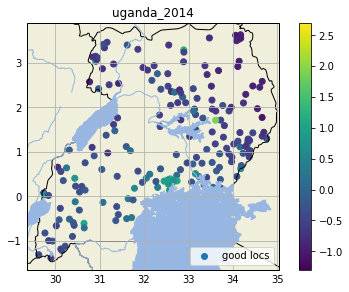

In [39]:
run_processing(country='uganda', years=[2014], year_range='2012-14')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2012-14_zambia_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1170, min value: -0.030607514083385468
  cluster_index: 300
  year: 2013
  lon: 33.16731643676758
Record 2 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 21564, min value: -0.02306240424513817
  cluster_index: 327
  year: 2013
  lon: 33.49711227416992
Record 3 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 22318, min value: -0.035119518637657166
  cluster_index: 526
  year: 2013
  lon: 33.54600143432617
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11129, min value: -0.018054332584142685
  cluster_index: 237
  year: 2013
  lon: 33.5168571472168
Record 5 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 20122, min value: -0.026426155120134354
  cluster_index: 697
  year: 2013
  lon: 33.416709899902344
Record 6 c

Record 55 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13306, min value: -0.0244157575070858
  cluster_index: 359
  year: 2013
  lon: 31.390836715698242
Record 56 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5825, min value: -0.018566761165857315
  cluster_index: 338
  year: 2013
  lon: 31.387956619262695
Record 57 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7175, min value: -0.015250638127326965
  cluster_index: 530
  year: 2013
  lon: 31.26955223083496
Record 58 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 945, min value: -0.005831562448292971
  cluster_index: 119
  year: 2013
  lon: 31.156198501586914
Record 61 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10, min value: -0.0036018225364387035
  cluster_index: 299
  year: 2013
  lon: 31.184919357299805
Record 66 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 368, min value: -0.0120

Record 109 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 34993, min value: -0.04264435917139053
  cluster_index: 608
  year: 2013
  lon: 29.6865234375
Record 110 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 41067, min value: -0.04573235288262367
  cluster_index: 235
  year: 2013
  lon: 29.6259822845459
Record 111 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 38107, min value: -0.05464395880699158
  cluster_index: 398
  year: 2013
  lon: 29.30750274658203
Record 112 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 34509, min value: -0.052993495017290115
  cluster_index: 172
  year: 2013
  lon: 28.72598648071289
Record 113 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 39057, min value: -0.04059646278619766
  cluster_index: 31
  year: 2013
  lon: 29.01227378845215
Record 114 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11193, min value: -0.04

Record 163 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 21654, min value: -0.023116644471883774
  cluster_index: 397
  year: 2013
  lon: 30.76137924194336
Record 164 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 9871, min value: -0.027370501309633255
  cluster_index: 21
  year: 2013
  lon: 30.60994529724121
Record 165 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 12274, min value: -0.01679323986172676
  cluster_index: 268
  year: 2013
  lon: 30.523456573486328
Record 166 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 21330, min value: -0.03259126469492912
  cluster_index: 647
  year: 2013
  lon: 30.365352630615234
Record 167 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10954, min value: -0.024071600288152695
  cluster_index: 27
  year: 2013
  lon: 29.978225708007812
Record 168 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 30496, min valu

Record 215 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10855, min value: -0.021058926358819008
  cluster_index: 20
  year: 2013
  lon: 32.828792572021484
Record 234 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 4592, min value: -0.009296298958361149
  cluster_index: 160
  year: 2013
  lon: 32.4081916809082
Record 235 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 14295, min value: -0.027642443776130676
  cluster_index: 473
  year: 2013
  lon: 32.62668228149414
Record 236 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 28481, min value: -0.03521868586540222
  cluster_index: 448
  year: 2013
  lon: 32.91119384765625
Record 237 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 16096, min value: -0.01735326647758484
  cluster_index: 698
  year: 2013
  lon: 32.762657165527344
Record 238 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 14009, min value

Record 288 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 40035, min value: -0.03766380250453949
  cluster_index: 533
  year: 2013
  lon: 29.796131134033203
Record 289 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1200, min value: -0.014097967185080051
  cluster_index: 703
  year: 2013
  lon: 28.746662139892578
Record 290 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1232, min value: -0.012540169060230255
  cluster_index: 525
  year: 2013
  lon: 28.727783203125
Record 291 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 14626, min value: -0.028188277035951614
  cluster_index: 223
  year: 2013
  lon: 28.94373893737793
Record 292 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8516, min value: -0.017067160457372665
  cluster_index: 207
  year: 2013
  lon: 28.832181930541992
Record 295 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 24548, min value

Record 404 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 6316, min value: -0.020570198073983192
  cluster_index: 201
  year: 2013
  lon: 26.494327545166016
Record 405 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 19371, min value: -0.029093876481056213
  cluster_index: 179
  year: 2013
  lon: 26.692138671875
Record 406 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 10065, min value: -0.021751176565885544
  cluster_index: 282
  year: 2013
  lon: 26.236860275268555
Record 407 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 18150, min value: -0.030695829540491104
  cluster_index: 263
  year: 2013
  lon: 26.37433433532715
Record 408 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 21262, min value: -0.03191737085580826
  cluster_index: 277
  year: 2013
  lon: 26.15863037109375
Record 409 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 13386, min valu

Record 464 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 328, min value: -0.01128721609711647
  cluster_index: 563
  year: 2013
  lon: 23.315383911132812
Record 465 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1488, min value: -0.007309164386242628
  cluster_index: 144
  year: 2013
  lon: 23.28099822998047
Record 466 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 29652, min value: -0.03569978103041649
  cluster_index: 383
  year: 2013
  lon: 23.022579193115234
Record 467 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 33544, min value: -0.04393536597490311
  cluster_index: 334
  year: 2013
  lon: 23.089168548583984
Record 468 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 24232, min value: -0.03554502874612808
  cluster_index: 246
  year: 2013
  lon: 23.243953704833984
Record 469 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 9772, min value:

Record 519 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 35678, min value: -0.05450094863772392
  cluster_index: 342
  year: 2013
  lon: 25.060161590576172
Record 520 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 14917, min value: -0.02605487033724785
  cluster_index: 73
  year: 2013
  lon: 25.500015258789062
Record 521 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 24686, min value: -0.02760966867208481
  cluster_index: 423
  year: 2013
  lon: 25.11767578125
Record 522 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 23127, min value: -0.04036591202020645
  cluster_index: 196
  year: 2013
  lon: 25.030248641967773
Record 523 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 23875, min value: -0.04781918600201607
  cluster_index: 230
  year: 2013
  lon: 25.0371036529541
Record 524 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 36735, min value: -0

Record 632 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 5448, min value: -0.024169251322746277
  cluster_index: 269
  year: 2013
  lon: 25.83791160583496
Record 633 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 39468, min value: -0.056665342301130295
  cluster_index: 536
  year: 2013
  lon: 25.986963272094727
Record 634 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 21690, min value: -0.032096557319164276
  cluster_index: 622
  year: 2013
  lon: 26.144775390625
Record 641 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 26168, min value: -0.04117851331830025
  cluster_index: 271
  year: 2013
  lon: 25.865894317626953
Record 642 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 15342, min value: -0.026926159858703613
  cluster_index: 70
  year: 2013
  lon: 25.929946899414062
Record 643 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 11843, min valu

Record 693 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 3154, min value: -0.027819041162729263
  cluster_index: 445
  year: 2013
  lon: 29.017793655395508
Record 694 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 8189, min value: -0.03182394430041313
  cluster_index: 64
  year: 2013
  lon: 30.539403915405273
Record 695 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 24833, min value: -0.02718687430024147
  cluster_index: 494
  year: 2013
  lon: 30.176738739013672
Record 696 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 9229, min value: -0.02615632861852646
  cluster_index: 652
  year: 2013
  lon: 30.575210571289062
Record 697 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 7596, min value: -0.03899415582418442
  cluster_index: 241
  year: 2013
  lon: 31.136999130249023
Record 703 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1891, min value: 

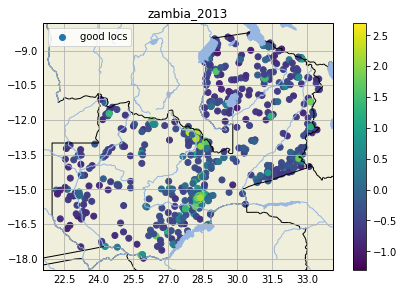

In [40]:
run_processing(country='zambia', years=[2013], year_range='2012-14')

### 2015 - 2017

In [41]:
# for country, years in COUNTRIES_TO_YEARS_2015_17.items():
#     run_processing(country, years, year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_angola_dhslocs_ee_export.tfrecord.gz
Record 287 contains negative bands: ['BLUE', 'NIR', 'SWIR1']
  Band 'BLUE' - count: 1, min value: -0.0003000000142492354
  Band 'NIR' - count: 1, min value: -0.006300000008195639
  Band 'SWIR1' - count: 1, min value: -0.0020000000949949026
  cluster_index: 71
  year: 2015
  lon: 12.354740142822266
Record 288 contains negative bands: ['BLUE', 'NIR', 'SWIR1']
  Band 'BLUE' - count: 1, min value: -0.0003000000142492354
  Band 'NIR' - count: 1, min value: -0.006300000008195639
  Band 'SWIR1' - count: 1, min value: -0.0020000000949949026
  cluster_index: 74
  year: 2015
  lon: 12.359700202941895
Record 289 contains negative bands: ['BLUE', 'NIR', 'SWIR1']
  Band 'BLUE' - count: 1, min value: -0.0003000000142492354
  Band 'NIR' - count: 1, min value: -0.006300000008195639
  Band 'SWIR1' - count: 1, min value: -0.0020000000949949026
  cluster_index: 576
  year: 2015
  lon: 12.36499309539795
Record

Record 552 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 511, min value: -0.005257117561995983
  cluster_index: 408
  year: 2015
  lon: 16.638174057006836
Record 561 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0008059673709794879
  cluster_index: 434
  year: 2015
  lon: 17.1666202545166
Record 567 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.004116581752896309
  cluster_index: 492
  year: 2015
  lon: 18.00772476196289
Record 578 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0008877607178874314
  cluster_index: 558
  year: 2015
  lon: 17.241182327270508
Record 612 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 48, min value: -0.0006191575666889548
  cluster_index: 20
  year: 2015
  lon: 21.485584259033203
Record 614 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0

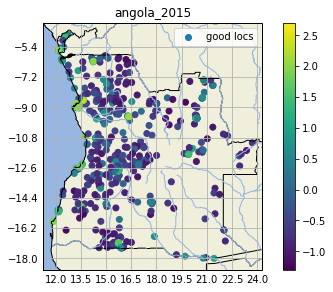

In [42]:
run_processing(country='angola', years=[2015], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_ethiopia_dhslocs_ee_export.tfrecord.gz
Record 131 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0025486962404102087
  cluster_index: 39
  year: 2016
  lon: 40.38005828857422
Record 143 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 15, min value: -0.001238444005139172
  cluster_index: 368
  year: 2016
  lon: 40.151145935058594
Record 150 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.008338944986462593
  cluster_index: 4
  year: 2016
  lon: 41.915794372558594
Record 151 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 544, min value: -0.0037964798975735903
  cluster_index: 75
  year: 2016
  lon: 41.70209503173828
Record 152 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1456, min value: -0.0071173119358718395
  cluster_index: 366
  year: 2016
  lon: 42.16313171386719
Recor

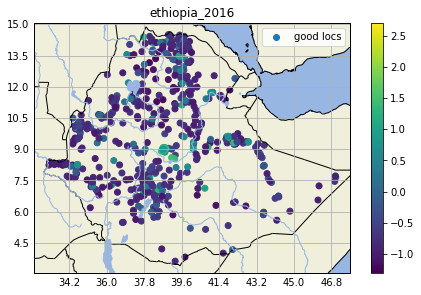

In [43]:
run_processing(country='ethiopia', years=[2016], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_ghana_dhslocs_ee_export.tfrecord.gz
Finished validating 192 records: 192 good, 0 bad


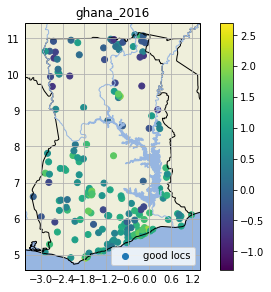

In [44]:
run_processing(country='ghana', years=[2016], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_kenya_dhslocs_ee_export.tfrecord.gz
Finished validating 245 records: 245 good, 0 bad


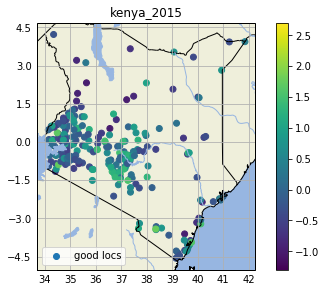

In [45]:
run_processing(country='kenya', years=[2015], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_malawi_dhslocs_ee_export.tfrecord.gz
Record 16 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0021560252644121647
  cluster_index: 301
  year: 2015
  lon: 35.23152542114258
Record 20 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.00443146051838994
  cluster_index: 645
  year: 2015
  lon: 35.22734832763672
Record 34 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 16, min value: -0.006617602426558733
  cluster_index: 400
  year: 2015
  lon: 34.92643737792969
Record 40 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 480, min value: -0.0014507384039461613
  cluster_index: 550
  year: 2015
  lon: 35.011436462402344
Record 45 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.004250693134963512
  cluster_index: 298
  year: 2015
  lon: 34.66700744628906
Record 125 c

Record 413 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 560, min value: -0.004612840246409178
  cluster_index: 358
  year: 2015
  lon: 34.51465606689453
Record 414 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 1808, min value: -0.0058557805605232716
  cluster_index: 625
  year: 2015
  lon: 34.525001525878906
Record 415 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 732, min value: -0.015274092555046082
  cluster_index: 284
  year: 2015
  lon: 34.855533599853516
Record 417 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2032, min value: -0.017219804227352142
  cluster_index: 214
  year: 2015
  lon: 35.2069206237793
Record 420 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2880, min value: -0.015011352486908436
  cluster_index: 70
  year: 2015
  lon: 35.14315414428711
Record 421 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.

Record 606 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 90, min value: -0.003090119920670986
  cluster_index: 460
  year: 2015
  lon: 34.19367218017578
Record 609 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 160, min value: -0.00497234333306551
  cluster_index: 159
  year: 2015
  lon: 34.15658950805664
Record 610 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.0024538550060242414
  cluster_index: 599
  year: 2015
  lon: 34.0443229675293
Record 611 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0009332167683169246
  cluster_index: 158
  year: 2015
  lon: 34.054832458496094
Record 614 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 544, min value: -0.006100032478570938
  cluster_index: 482
  year: 2015
  lon: 34.03939437866211
Record 615 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.0061

Record 728 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.00014046893920749426
  cluster_index: 747
  year: 2015
  lon: 33.815860748291016
Record 734 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.005644137039780617
  cluster_index: 136
  year: 2015
  lon: 34.02274703979492
Record 736 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 272, min value: -0.004420372657477856
  cluster_index: 85
  year: 2015
  lon: 34.08865737915039
Record 741 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0015593654243275523
  cluster_index: 726
  year: 2015
  lon: 34.215965270996094
Record 744 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 784, min value: -0.013369880616664886
  cluster_index: 448
  year: 2015
  lon: 34.30997085571289
Record 745 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 2027, min value: -0

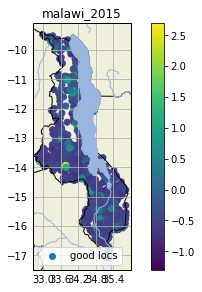

In [46]:
run_processing(country='malawi', years=[2015], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_mali_dhslocs_ee_export.tfrecord.gz
Finished validating 177 records: 177 good, 0 bad


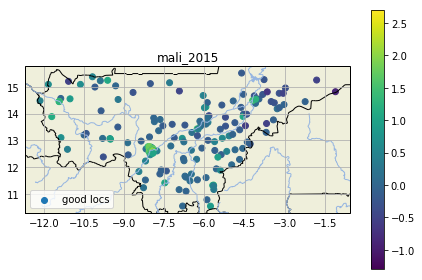

In [47]:
run_processing(country='mali', years=[2015], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_nigeria_dhslocs_ee_export.tfrecord.gz
Finished validating 322 records: 322 good, 0 bad


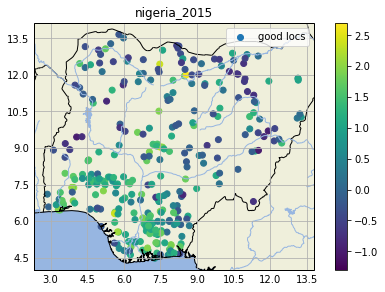

In [48]:
run_processing(country='nigeria', years=[2015], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_tanzania_dhslocs_ee_export.tfrecord.gz
Record 393 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.001328690443187952
  cluster_index: 462
  year: 2015
  lon: 34.38651657104492
Record 398 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 64, min value: -0.0006867359625175595
  cluster_index: 476
  year: 2015
  lon: 30.42578887939453
Record 548 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 225, min value: -0.0001836263108998537
  cluster_index: 506
  year: 2015
  lon: 33.7540168762207
Finished validating 608 records: 608 good, 0 bad


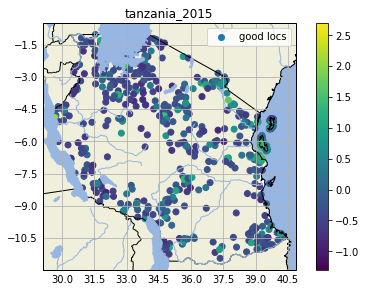

In [49]:
run_processing(country='tanzania', years=[2015], year_range='2015-17')

/atlas/u/chrisyeh/poverty_data/lxv3_water/lx_median_2015-17_zimbabwe_dhslocs_ee_export.tfrecord.gz
Record 0 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 256, min value: -0.004791361279785633
  cluster_index: 143
  year: 2015
  lon: 31.720598220825195
Record 4 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.0017812554724514484
  cluster_index: 178
  year: 2015
  lon: 32.018699645996094
Record 42 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 192, min value: -0.018203653395175934
  cluster_index: 230
  year: 2015
  lon: 32.186092376708984
Record 43 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 52, min value: -0.007835454307496548
  cluster_index: 380
  year: 2015
  lon: 32.00197219848633
Record 46 contains negative bands: ['NIGHTLIGHTS']
  Band 'NIGHTLIGHTS' - count: 240, min value: -0.002129285130649805
  cluster_index: 256
  year: 2015
  lon: 32.57536315917969
Record 54 

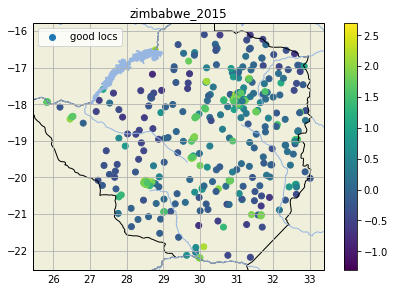

In [50]:
run_processing(country='zimbabwe', years=[2015], year_range='2015-17')